## Gruppenprojekt Marketing Analytics

Eingereicht von Roya Abdel Nasser, Karar Ghawami, Alexandra Gohr & Natalie Schwientek

In [2]:
import datetime as dt

import matplotlib.pyplot as plt

import numpy as np

from math import sqrt

import pandas as pd
from pandas.api.types import CategoricalDtype

#from prophet import Prophet
#from prophet.diagnostics import cross_validation
#from prophet.diagnostics import performance_metrics

import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_absolute_error as MSE
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split

import sktime
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.compose import make_reduction
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.base import ForecastingHorizon

from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import STL

import zipfile

%matplotlib inline
sns.set(rc={'figure.figsize':(20,10)})
pd.options.display.max_columns = 999

### 1. Data Preparation

In [3]:
dtypes_calendar_data = {
    'weekd_id' : 'int',
    'event_type_1' : 'category',
    'event_type_2' : 'category'
}

dtypes_prices_data = {
    'week_id' : 'int',
    'item_id' : 'category',
    'price' : 'float64'  
}

dtypes_sales_data = {
    'week_id' : 'int',
    'dept_id' : 'category',
    'cat_id' : 'category',
    'sales' : 'int',
    'item_id' : 'category'
}


calendar_data = pd.read_csv("calendar.csv",parse_dates = ['date'], dtype = dtypes_calendar_data)
prices_data = pd.read_csv("prices.csv", dtype = dtypes_prices_data)
zf = zipfile.ZipFile('ezyzip.zip') 
sales_data = pd.read_csv(zf.open('sales.csv'),parse_dates = ['date'], dtype = dtypes_sales_data)

display(calendar_data.head())
display(calendar_data.info())
display(prices_data.head())
display(prices_data.info())
display(sales_data.head())
display(sales_data.info())

date  week_id event_name_1 event_type_1 event_name_2 event_type_2  \
0 2011-02-01    11101          NaN          NaN          NaN          NaN   
1 2011-02-02    11101          NaN          NaN          NaN          NaN   
2 2011-02-03    11101          NaN          NaN          NaN          NaN   
3 2011-02-04    11101          NaN          NaN          NaN          NaN   
4 2011-02-05    11102          NaN          NaN          NaN          NaN   

   snap  
0     1  
1     1  
2     1  
3     1  
4     1

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1886 entries, 0 to 1885
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          1886 non-null   datetime64[ns]
 1   week_id       1886 non-null   int64         
 2   event_name_1  154 non-null    object        
 3   event_type_1  154 non-null    category      
 4   event_name_2  4 non-null      object        
 5   event_type_2  4 non-null      category      
 6   snap          1886 non-null   int64         
dtypes: category(2), datetime64[ns](1), int64(2), object(2)
memory usage: 77.7+ KB


None

Unnamed: 0        item_id  week_id  price
0           0  HOBBIES_1_001    11325   9.58
1           1  HOBBIES_1_001    11326   9.58
2           2  HOBBIES_1_001    11327   8.26
3           3  HOBBIES_1_001    11328   8.26
4           4  HOBBIES_1_001    11329   8.26

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 661824 entries, 0 to 661823
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype   
---  ------      --------------   -----   
 0   Unnamed: 0  661824 non-null  int64   
 1   item_id     661824 non-null  category
 2   week_id     661824 non-null  int32   
 3   price       661824 non-null  float64 
dtypes: category(1), float64(1), int32(1), int64(1)
memory usage: 14.0 MB


None

date        item_id    dept_id   cat_id  sales
0 2011-02-01  HOBBIES_1_001  HOBBIES_1  HOBBIES      0
1 2011-02-01  HOBBIES_1_002  HOBBIES_1  HOBBIES      0
2 2011-02-01  HOBBIES_1_003  HOBBIES_1  HOBBIES      0
3 2011-02-01  HOBBIES_1_004  HOBBIES_1  HOBBIES      0
4 2011-02-01  HOBBIES_1_005  HOBBIES_1  HOBBIES      0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5652846 entries, 0 to 5652845
Data columns (total 5 columns):
 #   Column   Dtype         
---  ------   -----         
 0   date     datetime64[ns]
 1   item_id  category      
 2   dept_id  category      
 3   cat_id   category      
 4   sales    int32         
dtypes: category(3), datetime64[ns](1), int32(1)
memory usage: 86.3 MB


None

In [4]:
merged_data = pd.merge(sales_data, calendar_data, on= "date")
merged_data.head()

date        item_id    dept_id   cat_id  sales  week_id event_name_1  \
0 2011-02-01  HOBBIES_1_001  HOBBIES_1  HOBBIES      0    11101          NaN   
1 2011-02-01  HOBBIES_1_002  HOBBIES_1  HOBBIES      0    11101          NaN   
2 2011-02-01  HOBBIES_1_003  HOBBIES_1  HOBBIES      0    11101          NaN   
3 2011-02-01  HOBBIES_1_004  HOBBIES_1  HOBBIES      0    11101          NaN   
4 2011-02-01  HOBBIES_1_005  HOBBIES_1  HOBBIES      0    11101          NaN   

  event_type_1 event_name_2 event_type_2  snap  
0          NaN          NaN          NaN     1  
1          NaN          NaN          NaN     1  
2          NaN          NaN          NaN     1  
3          NaN          NaN          NaN     1  
4          NaN          NaN          NaN     1

In [5]:
full_data = pd.merge(merged_data, prices_data, on= ["week_id", "item_id"])

display(full_data.info())
display(full_data.head(100))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4528539 entries, 0 to 4528538
Data columns (total 13 columns):
 #   Column        Dtype         
---  ------        -----         
 0   date          datetime64[ns]
 1   item_id       category      
 2   dept_id       category      
 3   cat_id        category      
 4   sales         int32         
 5   week_id       int64         
 6   event_name_1  object        
 7   event_type_1  category      
 8   event_name_2  object        
 9   event_type_2  category      
 10  snap          int64         
 11  Unnamed: 0    int64         
 12  price         float64       
dtypes: category(5), datetime64[ns](1), float64(1), int32(1), int64(3), object(2)
memory usage: 319.7+ MB


None

date        item_id    dept_id   cat_id  sales  week_id event_name_1  \
0  2011-02-01  HOBBIES_1_008  HOBBIES_1  HOBBIES      0    11101          NaN   
1  2011-02-02  HOBBIES_1_008  HOBBIES_1  HOBBIES      0    11101          NaN   
2  2011-02-03  HOBBIES_1_008  HOBBIES_1  HOBBIES      4    11101          NaN   
3  2011-02-04  HOBBIES_1_008  HOBBIES_1  HOBBIES      6    11101          NaN   
4  2011-02-01  HOBBIES_1_009  HOBBIES_1  HOBBIES      3    11101          NaN   
..        ...            ...        ...      ...    ...      ...          ...   
95 2011-02-04  HOBBIES_1_076  HOBBIES_1  HOBBIES      1    11101          NaN   
96 2011-02-01  HOBBIES_1_078  HOBBIES_1  HOBBIES      0    11101          NaN   
97 2011-02-02  HOBBIES_1_078  HOBBIES_1  HOBBIES      0    11101          NaN   
98 2011-02-03  HOBBIES_1_078  HOBBIES_1  HOBBIES      0    11101          NaN   
99 2011-02-04  HOBBIES_1_078  HOBBIES_1  HOBBIES      0    11101          NaN   

   event_type_1 event_name_2 event_type_2  snap  Unnamed: 0  price  
0           NaN          NaN          NaN     1        1512   0.46  
1           NaN          NaN          NaN     1        1512   0.46  
2           NaN          NaN          NaN     1        1512   0.46  
3           NaN          NaN          NaN     1        1512   0.46  
4           NaN          NaN          NaN     1        1794   1.56  
..          ...          ...          ...   ...         ...    ...  
95          NaN          NaN          NaN     1       17276   2.94  
96          NaN          NaN          NaN     1       17781  11.97  
97          NaN          NaN          NaN     1       17781  11.97  
98          NaN          NaN          NaN     1       17781  11.97  
99          NaN          NaN          NaN     1       17781  11.97  

[100 rows x 13 columns]

In [6]:
full_data.set_index(['date'], inplace = True)
full_data.sort_index(axis = 0, ascending = True, inplace = True)
display(full_data.head(10))

item_id      dept_id     cat_id  sales  week_id  \
date                                                                  
2011-02-01    HOBBIES_1_008    HOBBIES_1    HOBBIES      0    11101   
2011-02-01      FOODS_2_207      FOODS_2      FOODS      0    11101   
2011-02-01  HOUSEHOLD_1_327  HOUSEHOLD_1  HOUSEHOLD      1    11101   
2011-02-01      FOODS_2_208      FOODS_2      FOODS      0    11101   
2011-02-01      FOODS_2_211      FOODS_2      FOODS      1    11101   
2011-02-01  HOUSEHOLD_1_325  HOUSEHOLD_1  HOUSEHOLD      0    11101   
2011-02-01      FOODS_2_212      FOODS_2      FOODS      4    11101   
2011-02-01  HOUSEHOLD_1_324  HOUSEHOLD_1  HOUSEHOLD      0    11101   
2011-02-01      FOODS_2_218      FOODS_2      FOODS      1    11101   
2011-02-01      FOODS_2_219      FOODS_2      FOODS      0    11101   

           event_name_1 event_type_1 event_name_2 event_type_2  snap  \
date                                                                   
2011-02-01          NaN          NaN          NaN          NaN     1   
2011-02-01          NaN          NaN          NaN          NaN     1   
2011-02-01          NaN          NaN          NaN          NaN     1   
2011-02-01          NaN          NaN          NaN          NaN     1   
2011-02-01          NaN          NaN          NaN          NaN     1   
2011-02-01          NaN          NaN          NaN          NaN     1   
2011-02-01          NaN          NaN          NaN          NaN     1   
2011-02-01          NaN          NaN          NaN          NaN     1   
2011-02-01          NaN          NaN          NaN          NaN     1   
2011-02-01          NaN          NaN          NaN          NaN     1   

            Unnamed: 0  price  
date                           
2011-02-01        1512   0.46  
2011-02-01      467458   6.84  
2011-02-01      200374   0.94  
2011-02-01      467740   6.98  
2011-02-01      468152   2.64  
2011-02-01      199811   3.32  
2011-02-01      468434   4.18  
2011-02-01      199529   5.97  
2011-02-01      469570   3.25  
2011-02-01      469852   2.98

In [7]:
full_data_clean = full_data.drop("Unnamed: 0", axis=1)
full_data_clean.head()

item_id      dept_id     cat_id  sales  week_id  \
date                                                                  
2011-02-01    HOBBIES_1_008    HOBBIES_1    HOBBIES      0    11101   
2011-02-01      FOODS_2_207      FOODS_2      FOODS      0    11101   
2011-02-01  HOUSEHOLD_1_327  HOUSEHOLD_1  HOUSEHOLD      1    11101   
2011-02-01      FOODS_2_208      FOODS_2      FOODS      0    11101   
2011-02-01      FOODS_2_211      FOODS_2      FOODS      1    11101   

           event_name_1 event_type_1 event_name_2 event_type_2  snap  price  
date                                                                         
2011-02-01          NaN          NaN          NaN          NaN     1   0.46  
2011-02-01          NaN          NaN          NaN          NaN     1   6.84  
2011-02-01          NaN          NaN          NaN          NaN     1   0.94  
2011-02-01          NaN          NaN          NaN          NaN     1   6.98  
2011-02-01          NaN          NaN          NaN          NaN     1   2.64

Als zusätziche erklärende Variablen werden der jeweilige Name und Wochentag eingefügt. Um die einzelnen Variaben in die Modelle einfließen lassen zu können, werden diese binär kodiert und zu Dummy-Variablen transformiert

In [8]:
#Dummy-variablen codieren
full_data_clean['Month'] = full_data_clean.index.month_name()
full_data_clean['Weekday'] = full_data_clean.index.day_name()
data = pd.get_dummies(full_data_clean, columns = ['event_name_1','event_type_1','event_name_2','event_type_2', 'Month', 'Weekday'], drop_first = False)
data.head(20)

item_id      dept_id     cat_id  sales  week_id  snap  \
date                                                                        
2011-02-01    HOBBIES_1_008    HOBBIES_1    HOBBIES      0    11101     1   
2011-02-01      FOODS_2_207      FOODS_2      FOODS      0    11101     1   
2011-02-01  HOUSEHOLD_1_327  HOUSEHOLD_1  HOUSEHOLD      1    11101     1   
2011-02-01      FOODS_2_208      FOODS_2      FOODS      0    11101     1   
2011-02-01      FOODS_2_211      FOODS_2      FOODS      1    11101     1   
2011-02-01  HOUSEHOLD_1_325  HOUSEHOLD_1  HOUSEHOLD      0    11101     1   
2011-02-01      FOODS_2_212      FOODS_2      FOODS      4    11101     1   
2011-02-01  HOUSEHOLD_1_324  HOUSEHOLD_1  HOUSEHOLD      0    11101     1   
2011-02-01      FOODS_2_218      FOODS_2      FOODS      1    11101     1   
2011-02-01      FOODS_2_219      FOODS_2      FOODS      0    11101     1   
2011-02-01  HOUSEHOLD_1_316  HOUSEHOLD_1  HOUSEHOLD      1    11101     1   
2011-02-01      FOODS_2_220      FOODS_2      FOODS      4    11101     1   
2011-02-01  HOUSEHOLD_1_313  HOUSEHOLD_1  HOUSEHOLD      0    11101     1   
2011-02-01      FOODS_2_221      FOODS_2      FOODS      5    11101     1   
2011-02-01      FOODS_2_225      FOODS_2      FOODS      2    11101     1   
2011-02-01  HOUSEHOLD_1_310  HOUSEHOLD_1  HOUSEHOLD      0    11101     1   
2011-02-01      FOODS_2_229      FOODS_2      FOODS      0    11101     1   
2011-02-01  HOUSEHOLD_1_309  HOUSEHOLD_1  HOUSEHOLD      1    11101     1   
2011-02-01      FOODS_2_230      FOODS_2      FOODS      0    11101     1   
2011-02-01      FOODS_2_231      FOODS_2      FOODS      1    11101     1   

            price  event_name_1_Chanukah End  event_name_1_Christmas  \
date                                                                   
2011-02-01   0.46                          0                       0   
2011-02-01   6.84                          0                       0   
2011-02-01   0.94                          0                       0   
2011-02-01   6.98                          0                       0   
2011-02-01   2.64                          0                       0   
2011-02-01   3.32                          0                       0   
2011-02-01   4.18                          0                       0   
2011-02-01   5.97                          0                       0   
2011-02-01   3.25                          0                       0   
2011-02-01   2.98                          0                       0   
2011-02-01   3.98                          0                       0   
2011-02-01   1.98                          0                       0   
2011-02-01   4.47                          0                       0   
2011-02-01   1.34                          0                       0   
2011-02-01   2.50                          0                       0   
2011-02-01   7.97                          0                       0   
2011-02-01   2.34                          0                       0   
2011-02-01   6.53                          0                       0   
2011-02-01   2.34                          0                       0   
2011-02-01   2.98                          0                       0   

            event_name_1_Cinco De Mayo  event_name_1_ColumbusDay  \
date                                                               
2011-02-01                           0                         0   
2011-02-01                           0                         0   
2011-02-01                           0                         0   
2011-02-01                           0                         0   
2011-02-01                           0                         0   
2011-02-01                           0                         0   
2011-02-01                           0                         0   
2011-02-01                           0                         0   
2011-02-01                           0                      

In [9]:
data.item_id.value_counts()

FOODS_1_001      1854
HOBBIES_1_063    1854
HOBBIES_1_086    1854
HOBBIES_1_084    1854
HOBBIES_1_082    1854
                 ... 
FOODS_2_248       128
FOODS_2_117        65
FOODS_2_209        65
FOODS_3_296        44
FOODS_3_595        16
Name: item_id, Length: 3049, dtype: int64

In [10]:
# Daten auf Tagesbasis aggregieren
data_grouped = data.groupby('date').apply(

        lambda data: pd.Series({
            'sales':                           data.sales.sum(),
            'snap': data.snap.max(),
            
       #    'dept_id_FOODS_1' : data.dept_id_FOODS_1.max(),
        #   'dept_id_FOODS_2' : data.dept_id_FOODS_2.max(),
         #  'dept_id_FOODS_3' : data.dept_id_FOODS_3.max(),

          # 'dept_id_HOBBIES_1' : data.dept_id_HOBBIES_1.max(),
           #'dept_id_HOBBIES_2' : data.dept_id_HOBBIES_2.max(),
          
           #'dept_id_HOUSEHOLD_1' : data.dept_id_HOUSEHOLD_1.max(),
           #'dept_id_HOUSEHOLD_2' : data.dept_id_HOUSEHOLD_2.max(),
            
            'mean_price_food':      data.loc[data.cat_id == 'FOODS', 'price'].mean(),            
            'mean_price_hobbies':   data.loc[data.cat_id == 'HOBBIES', 'price'].mean(),
            'mean_price_household': data.loc[data.cat_id == 'HOUSEHOLD', 'price'].mean(),

          
            'event_type_1_Cultural' : data.event_type_1_Cultural.max(), 
            'event_type_1_National': data.event_type_1_National.max(), 
            'event_type_1_Religious': data.event_type_1_Religious.max(), 
            'event_type_1_Sporting': data.event_type_1_Sporting.max(), 
            'event_type_2_Cultural' : data.event_type_2_Cultural.max(), 
            'event_type_2_Religious': data.event_type_2_Religious.max(), 
            
            'Month_April': data.Month_April.max(),
            'Month_August': data.Month_August.max(),
            'Month_December': data.Month_December.max(),
            'Month_February': data.Month_February.max(),
            'Month_January': data.Month_January.max(),
            'Month_July': data.Month_July.max(),
            'Month_June': data.Month_June.max(),
            'Month_March': data.Month_March.max(),
            'Month_May': data.Month_May.max(),
            'Month_November': data.Month_November.max(),
            'Month_October': data.Month_October.max(),
            'Month_September': data.Month_September.max(),
            
            'Weekday_Friday':   data.Weekday_Friday.max(),
            'Weekday_Monday':   data.Weekday_Monday.max(),
            'Weekday_Saturday': data.Weekday_Saturday.max(),
            'Weekday_Sunday':   data.Weekday_Sunday.max(),
            'Weekday_Thursday': data.Weekday_Thursday.max(),
            'Weekday_Tuesday':  data.Weekday_Tuesday.max(),
            'Weekday_Wednesday':data.Weekday_Wednesday.max()
                               
       }))
data_grouped.head(20)

# cat ID: überlegen, ob Aggregation mit .sum() oder .max () sinnvoll. Bei sum - Anzahl der (einzelnen) Items pro Kategorie pro Tag
# max: Ja/Nein, ob innerhalb dieser Kategorie gekauft wurde -- ist aber jeden Tag der Fall gibt daher keinen Aufschluss auf Sales. Ebenso bei Dept ID

sales  snap  mean_price_food  mean_price_hobbies  \
date                                                            
2011-02-01  3051.0   1.0         3.149220            4.468814   
2011-02-02  2630.0   1.0         3.149220            4.468814   
2011-02-03  3276.0   1.0         3.149220            4.468814   
2011-02-04  3450.0   1.0         3.149220            4.468814   
2011-02-05  5437.0   1.0         3.153394            4.406516   
2011-02-06  4340.0   1.0         3.153394            4.406516   
2011-02-07  3157.0   1.0         3.153394            4.406516   
2011-02-08  2995.0   1.0         3.153394            4.406516   
2011-02-09  2710.0   1.0         3.153394            4.406516   
2011-02-10  2928.0   1.0         3.153394            4.406516   
2011-02-11  3078.0   0.0         3.153394            4.406516   
2011-02-12  4316.0   0.0         3.129630            4.459241   
2011-02-13  4354.0   0.0         3.129630            4.459241   
2011-02-14  2757.0   0.0         3.129630            4.459241   
2011-02-15  2430.0   0.0         3.129630            4.459241   
2011-02-16  2272.0   0.0         3.129630            4.459241   
2011-02-17  2009.0   0.0         3.129630            4.459241   
2011-02-18  3015.0   0.0         3.129630            4.459241   
2011-02-19  4553.0   0.0         3.123212            4.422090   
2011-02-20  3966.0   0.0         3.123212            4.422090   

            mean_price_household  event_type_1_Cultural  \
date                                                      
2011-02-01              5.416099                    0.0   
2011-02-02              5.416099                    0.0   
2011-02-03              5.416099                    0.0   
2011-02-04              5.416099                    0.0   
2011-02-05              5.509579                    0.0   
2011-02-06              5.509579                    0.0   
2011-02-07              5.509579                    0.0   
2011-02-08              5.509579                    0.0   
2011-02-09              5.509579                    0.0   
2011-02-10              5.509579                    0.0   
2011-02-11              5.509579                    0.0   
2011-02-12              5.578825                    0.0   
2011-02-13              5.578825                    0.0   
2011-02-14              5.578825                    1.0   
2011-02-15              5.578825                    0.0   
2011-02-16              5.578825                    0.0   
2011-02-17              5.578825                    0.0   
2011-02-18              5.578825                    0.0   
2011-02-19              5.580215                    0.0   
2011-02-20              5.580215                    0.0   

            event_type_1_National  event_type_1_Religious  \
date                                                        
2011-02-01                    0.0                     0.0   
2011-02-02                    0.0                     0.0   
2011-02-03                    0.0                     0.0   
2011-02-04                    0.0                     0.0   
2011-02-05                    0.0                     0.0   
2011-02-06                    0.0                     0.0   
2011-02-07                    0.0                     0.0   
2011-02-08                    0.0                     0.0   
2011-02-09                    0.0                     0.0   
2011-02-10                    0.0                     0.0   
2011-02-11                    0.0                     0.0   
2011-02-12                    0.0                     0.0   
2011-02-13                    0.0                     0.0   
2011-02-14                    0.0                     0.0   
2011-02-15                    0.0                     0.0   
2011-02-16                    0.0                     0.0   
2011-02-17                    0.0                     0.0   
2011-02-18                    0.0                     0.0   
2011-02-19                    0.0                     0.0   
20

In [11]:
data_grouped.mean_price_food.value_counts()

3.245413    5
3.264314    4
3.254275    3
3.241860    3
3.259583    3
           ..
3.308297    1
3.308297    1
3.308297    1
3.308297    1
3.344057    1
Name: mean_price_food, Length: 1573, dtype: int64

<AxesSubplot:xlabel='date', ylabel='mean_price_food'>

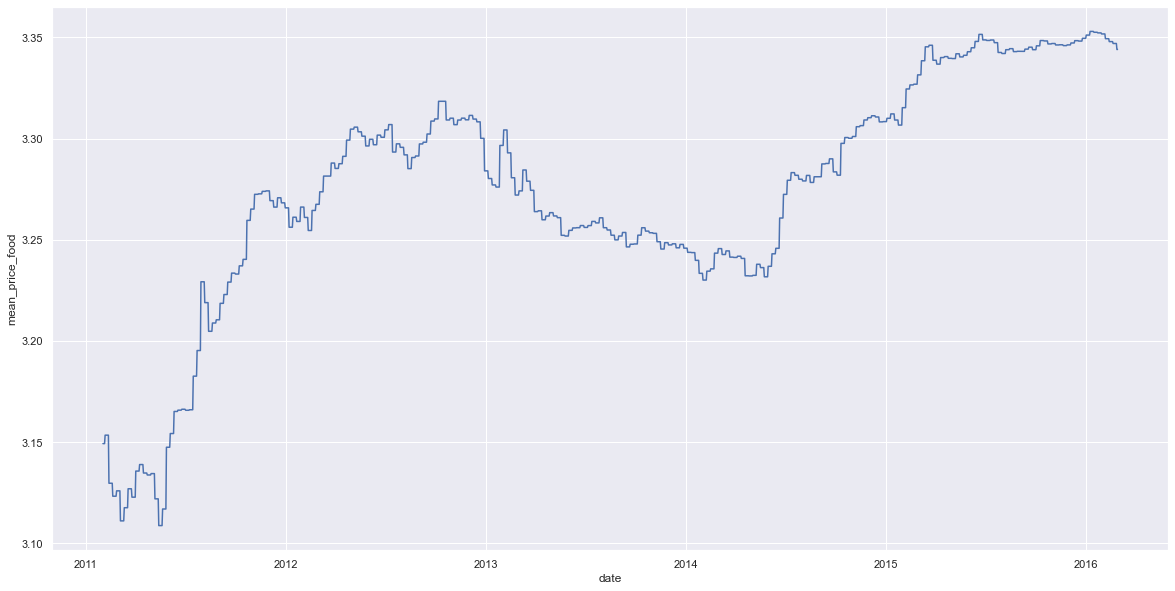

In [12]:
# Darstellung der Preisentwicklung in der Kategorie Food
sns.lineplot(x = 'date', y = 'mean_price_food', data = data_grouped, estimator = 'mean')

<AxesSubplot:xlabel='date', ylabel='mean_price_hobbies'>

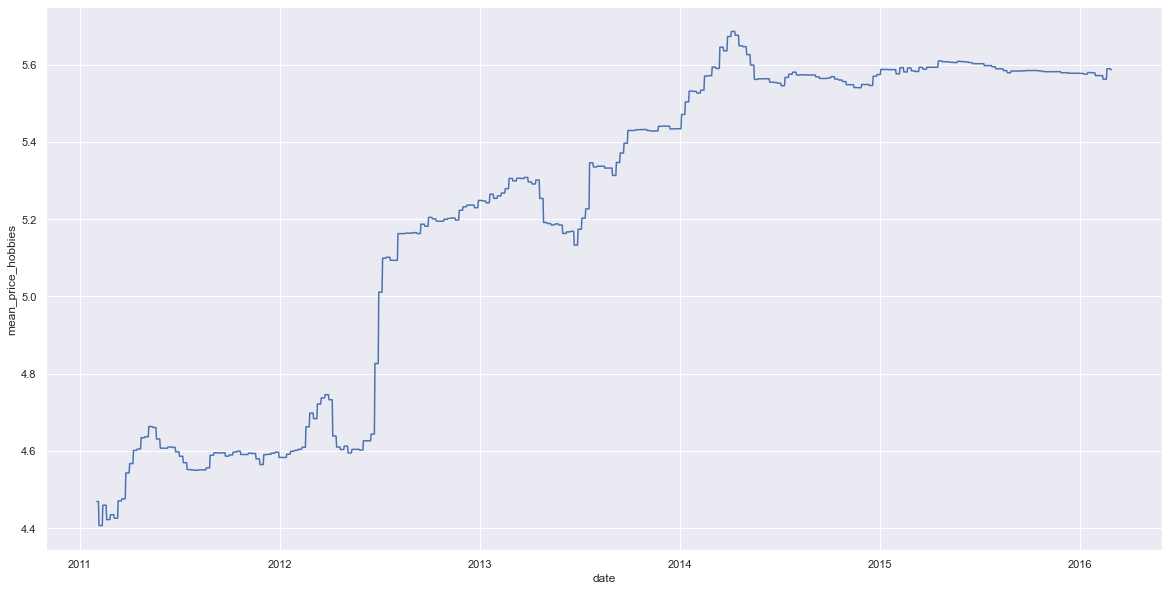

In [13]:
# Darstellung der Preisentwicklung in der Kategorie Hobbies
sns.lineplot(x = 'date', y = 'mean_price_hobbies', data = data_grouped, estimator = 'mean')

<AxesSubplot:xlabel='date', ylabel='mean_price_household'>

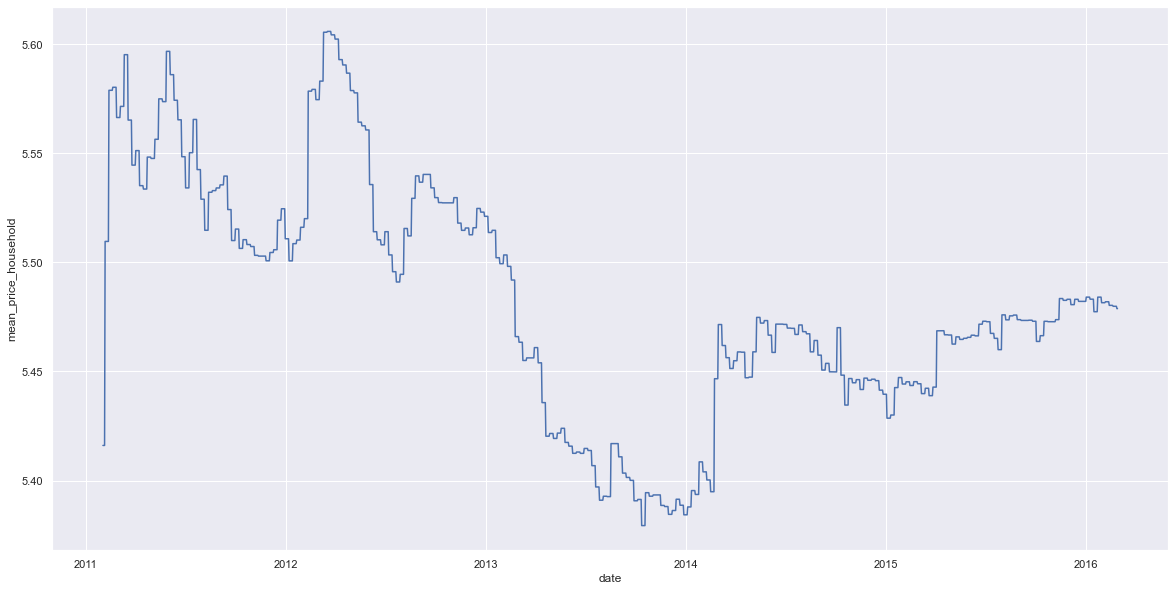

In [14]:
# Darstellung der Preisentwicklung in der Kategorie Household
sns.lineplot(x = 'date', y = 'mean_price_household', data = data_grouped, estimator = 'mean')

Die Preisverlaufsdiagramme zeigen, dass die Preisentwicklung in den verschiedenen Kategorien sehr unterschiedlich verläuft. Da wir vermuten, dass die Preise einen hohen Einfluss auf den Absatz haben, wird der ursprüngliche Datensatz für die nächsten Schritte in drei einzelne Datensätze unterteilt, um die Prognose detaillierter pro Kategorie abzubilden

In [15]:
#Aggregation pro Kategorie
data_food = data.loc[data['cat_id'] == 'FOODS']
data_household = data.loc[data['cat_id'] == 'HOUSEHOLD']
data_hobbies = data.loc[data['cat_id'] == 'HOBBIES']

In [16]:
food_grouped = data_food.groupby('date').apply(

        lambda data_food: pd.Series({
            'sales':                           data_food.sales.sum(),
            'snap': data_food.snap.max(),
            
       #    'dept_id_FOODS_1' : data.dept_id_FOODS_1.max(),
        #   'dept_id_FOODS_2' : data.dept_id_FOODS_2.max(),
         #  'dept_id_FOODS_3' : data.dept_id_FOODS_3.max(),

          # 'dept_id_HOBBIES_1' : data.dept_id_HOBBIES_1.max(),
           #'dept_id_HOBBIES_2' : data.dept_id_HOBBIES_2.max(),
          
           #'dept_id_HOUSEHOLD_1' : data.dept_id_HOUSEHOLD_1.max(),
           #'dept_id_HOUSEHOLD_2' : data.dept_id_HOUSEHOLD_2.max(),
            
            'mean_price_dept1':   data_food.loc[data_food.dept_id == 'FOODS_1', 'price'].mean(),            
            'mean_price_dept2':   data_food.loc[data_food.dept_id == 'FOODS_2', 'price'].mean(),
            'mean_price_dept3':   data_food.loc[data_food.dept_id == 'FOODS_3', 'price'].mean(),

          
            'event_type_1_Cultural' : data_food.event_type_1_Cultural.max(), 
            'event_type_1_National': data_food.event_type_1_National.max(), 
            'event_type_1_Religious': data_food.event_type_1_Religious.max(), 
            'event_type_1_Sporting': data_food.event_type_1_Sporting.max(), 
            'event_type_2_Cultural' : data_food.event_type_2_Cultural.max(), 
            'event_type_2_Religious': data_food.event_type_2_Religious.max(), 
            
            'Month_April': data_food.Month_April.max(),
            'Month_August': data_food.Month_August.max(),
            'Month_December': data_food.Month_December.max(),
            'Month_February': data_food.Month_February.max(),
            'Month_January': data_food.Month_January.max(),
            'Month_July': data_food.Month_July.max(),
            'Month_June': data_food.Month_June.max(),
            'Month_March': data_food.Month_March.max(),
            'Month_May': data_food.Month_May.max(),
            'Month_November': data_food.Month_November.max(),
            'Month_October': data_food.Month_October.max(),
            'Month_September': data_food.Month_September.max(),
            
            'Weekday_Friday':   data_food.Weekday_Friday.max(),
            'Weekday_Monday':   data_food.Weekday_Monday.max(),
            'Weekday_Saturday': data_food.Weekday_Saturday.max(),
            'Weekday_Sunday':   data_food.Weekday_Sunday.max(),
            'Weekday_Thursday': data_food.Weekday_Thursday.max(),
            'Weekday_Tuesday':  data_food.Weekday_Tuesday.max(),
            'Weekday_Wednesday':data_food.Weekday_Wednesday.max()
                               
       }))
food_grouped.head(20)

sales  snap  mean_price_dept1  mean_price_dept2  \
date                                                           
2011-02-01  2258.0   1.0          2.989109          3.807460   
2011-02-02  2032.0   1.0          2.989109          3.807460   
2011-02-03  2407.0   1.0          2.989109          3.807460   
2011-02-04  2693.0   1.0          2.989109          3.807460   
2011-02-05  3962.0   1.0          3.016636          3.875838   
2011-02-06  3418.0   1.0          3.016636          3.875838   
2011-02-07  2446.0   1.0          3.016636          3.875838   
2011-02-08  2138.0   1.0          3.016636          3.875838   
2011-02-09  2001.0   1.0          3.016636          3.875838   
2011-02-10  2137.0   1.0          3.016636          3.875838   
2011-02-11  2217.0   0.0          3.016636          3.875838   
2011-02-12  3067.0   0.0          2.999455          3.868223   
2011-02-13  3313.0   0.0          2.999455          3.868223   
2011-02-14  2003.0   0.0          2.999455          3.868223   
2011-02-15  1779.0   0.0          2.999455          3.868223   
2011-02-16  1670.0   0.0          2.999455          3.868223   
2011-02-17  1433.0   0.0          2.999455          3.868223   
2011-02-18  2250.0   0.0          2.999455          3.868223   
2011-02-19  3148.0   0.0          2.977143          3.863518   
2011-02-20  2864.0   0.0          2.977143          3.863518   

            mean_price_dept3  event_type_1_Cultural  event_type_1_National  \
date                                                                         
2011-02-01          2.828994                    0.0                    0.0   
2011-02-02          2.828994                    0.0                    0.0   
2011-02-03          2.828994                    0.0                    0.0   
2011-02-04          2.828994                    0.0                    0.0   
2011-02-05          2.797716                    0.0                    0.0   
2011-02-06          2.797716                    0.0                    0.0   
2011-02-07          2.797716                    0.0                    0.0   
2011-02-08          2.797716                    0.0                    0.0   
2011-02-09          2.797716                    0.0                    0.0   
2011-02-10          2.797716                    0.0                    0.0   
2011-02-11          2.797716                    0.0                    0.0   
2011-02-12          2.773152                    0.0                    0.0   
2011-02-13          2.773152                    0.0                    0.0   
2011-02-14          2.773152                    1.0                    0.0   
2011-02-15          2.773152                    0.0                    0.0   
2011-02-16          2.773152                    0.0                    0.0   
2011-02-17          2.773152                    0.0                    0.0   
2011-02-18          2.773152                    0.0                    0.0   
2011-02-19          2.773048                    0.0                    0.0   
2011-02-20          2.773048                    0.0                    0.0   

            event_type_1_Religious  event_type_1_Sporting  \
date                                                        
2011-02-01                     0.0                    0.0   
2011-02-02                     0.0                    0.0   
2011-02-03                     0.0                    0.0   
2011-02-04                     0.0                    0.0   
2011-02-05                     0.0                    0.0   
2011-02-06                     0.0                    1.0   
2011-02-07                     0.0                    0.0   
2011-02-08                     0.0                    0.0   
2011-02-09                     0.0                    0.0   
2011-02-10                     0.0                    0.0   
2011-02-11                     0.0                    0.0   
2011-02-12                     0.0                    0.0   
2011-02-13                     0.

In [17]:
hobbies_grouped = data_hobbies.groupby('date').apply(

        lambda data_hobbies: pd.Series({
            'sales':                           data_hobbies.sales.sum(),
           # 'snap': data.snap.max(),
            
       #    'dept_id_FOODS_1' : data.dept_id_FOODS_1.max(),
        #   'dept_id_FOODS_2' : data.dept_id_FOODS_2.max(),
         #  'dept_id_FOODS_3' : data.dept_id_FOODS_3.max(),

          # 'dept_id_HOBBIES_1' : data.dept_id_HOBBIES_1.max(),
           #'dept_id_HOBBIES_2' : data.dept_id_HOBBIES_2.max(),
          
           #'dept_id_HOUSEHOLD_1' : data.dept_id_HOUSEHOLD_1.max(),
           #'dept_id_HOUSEHOLD_2' : data.dept_id_HOUSEHOLD_2.max(),
            
            'mean_price_dept1':   data_hobbies.loc[data_hobbies.dept_id == 'HOBBIES_1', 'price'].mean(),            
            'mean_price_dept2':   data_hobbies.loc[data_hobbies.dept_id == 'HOBBIES_2', 'price'].mean(),

          
            'event_type_1_Cultural' : data_hobbies.event_type_1_Cultural.max(), 
            'event_type_1_National': data_hobbies.event_type_1_National.max(), 
            'event_type_1_Religious': data_hobbies.event_type_1_Religious.max(), 
            'event_type_1_Sporting': data_hobbies.event_type_1_Sporting.max(), 
            'event_type_2_Cultural' : data_hobbies.event_type_2_Cultural.max(), 
            'event_type_2_Religious': data_hobbies.event_type_2_Religious.max(), 
            
            'Month_April': data_hobbies.Month_April.max(),
            'Month_August': data_hobbies.Month_August.max(),
            'Month_December': data_hobbies.Month_December.max(),
            'Month_February': data_hobbies.Month_February.max(),
            'Month_January': data_hobbies.Month_January.max(),
            'Month_July': data_hobbies.Month_July.max(),
            'Month_June': data_hobbies.Month_June.max(),
            'Month_March': data_hobbies.Month_March.max(),
            'Month_May': data_hobbies.Month_May.max(),
            'Month_November': data_hobbies.Month_November.max(),
            'Month_October': data_hobbies.Month_October.max(),
            'Month_September': data_hobbies.Month_September.max(),
            
             
            'Weekday_Friday':   data_hobbies.Weekday_Friday.max(),
            'Weekday_Monday':   data_hobbies.Weekday_Monday.max(),
            'Weekday_Saturday': data_hobbies.Weekday_Saturday.max(),
            'Weekday_Sunday':   data_hobbies.Weekday_Sunday.max(),
            'Weekday_Thursday': data_hobbies.Weekday_Thursday.max(),
            'Weekday_Tuesday':  data_hobbies.Weekday_Tuesday.max(),
            'Weekday_Wednesday':data_hobbies.Weekday_Wednesday.max()
                               
       }))
hobbies_grouped.head(20)

sales  mean_price_dept1  mean_price_dept2  event_type_1_Cultural  \
date                                                                           
2011-02-01  392.0          4.773416          2.982727                    0.0   
2011-02-02  268.0          4.773416          2.982727                    0.0   
2011-02-03  467.0          4.773416          2.982727                    0.0   
2011-02-04  346.0          4.773416          2.982727                    0.0   
2011-02-05  769.0          4.847572          2.816875                    0.0   
2011-02-06  432.0          4.847572          2.816875                    0.0   
2011-02-07  384.0          4.847572          2.816875                    0.0   
2011-02-08  496.0          4.847572          2.816875                    0.0   
2011-02-09  399.0          4.847572          2.816875                    0.0   
2011-02-10  454.0          4.847572          2.816875                    0.0   
2011-02-11  453.0          4.847572          2.816875                    0.0   
2011-02-12  692.0          4.954751          2.857679                    0.0   
2011-02-13  458.0          4.954751          2.857679                    0.0   
2011-02-14  379.0          4.954751          2.857679                    1.0   
2011-02-15  334.0          4.954751          2.857679                    0.0   
2011-02-16  270.0          4.954751          2.857679                    0.0   
2011-02-17  280.0          4.954751          2.857679                    0.0   
2011-02-18  311.0          4.954751          2.857679                    0.0   
2011-02-19  793.0          4.947011          2.812333                    0.0   
2011-02-20  501.0          4.947011          2.812333                    0.0   

            event_type_1_National  event_type_1_Religious  \
date                                                        
2011-02-01                    0.0                     0.0   
2011-02-02                    0.0                     0.0   
2011-02-03                    0.0                     0.0   
2011-02-04                    0.0                     0.0   
2011-02-05                    0.0                     0.0   
2011-02-06                    0.0                     0.0   
2011-02-07                    0.0                     0.0   
2011-02-08                    0.0                     0.0   
2011-02-09                    0.0                     0.0   
2011-02-10                    0.0                     0.0   
2011-02-11                    0.0                     0.0   
2011-02-12                    0.0                     0.0   
2011-02-13                    0.0                     0.0   
2011-02-14                    0.0                     0.0   
2011-02-15                    0.0                     0.0   
2011-02-16                    0.0                     0.0   
2011-02-17                    0.0                     0.0   
2011-02-18                    0.0                     0.0   
2011-02-19                    0.0                     0.0   
2011-02-20                    0.0                     0.0   

            event_type_1_Sporting  event_type_2_Cultural  \
date                                                       
2011-02-01                    0.0                    0.0   
2011-02-02                    0.0                    0.0   
2011-02-03                    0.0                    0.0   
2011-02-04                    0.0                    0.0   
2011-02-05                    0.0                    0.0   
2011-02-06                    1.0                    0.0   
2011-02-07                    0.0                    0.0   
2011-02-08                    0.0                    0.0   
2011-02-09                    0.0                    0.0   
2011-02-10                    0.0                    0.0   
2011-02-11                    0.0                    0.0   
2011-02-12                    0.0                    0.0   
2011-02-13                    0.0                    0.0   
2011-02-

In [18]:
household_grouped = data_household.groupby('date').apply(

        lambda data_household: pd.Series({
            'sales':                           data_household.sales.sum(),
         #   'snap': data.snap.max(),
            
       #    'dept_id_FOODS_1' : data.dept_id_FOODS_1.max(),
        #   'dept_id_FOODS_2' : data.dept_id_FOODS_2.max(),
         #  'dept_id_FOODS_3' : data.dept_id_FOODS_3.max(),

          # 'dept_id_HOBBIES_1' : data.dept_id_HOBBIES_1.max(),
           #'dept_id_HOBBIES_2' : data.dept_id_HOBBIES_2.max(),
          
           #'dept_id_HOUSEHOLD_1' : data.dept_id_HOUSEHOLD_1.max(),
           #'dept_id_HOUSEHOLD_2' : data.dept_id_HOUSEHOLD_2.max(),
            
            'mean_price_dept1':   data_household.loc[data_household.dept_id == 'HOUSEHOLD_1', 'price'].mean(),            
            'mean_price_dept2':   data_household.loc[data_household.dept_id == 'HOUSEHOLD_2', 'price'].mean(),
                     
            'event_type_1_Cultural' : data_household.event_type_1_Cultural.max(), 
            'event_type_1_National': data_household.event_type_1_National.max(), 
            'event_type_1_Religious': data_household.event_type_1_Religious.max(), 
            'event_type_1_Sporting': data_household.event_type_1_Sporting.max(), 
            'event_type_2_Cultural' : data_household.event_type_2_Cultural.max(), 
            'event_type_2_Religious': data_household.event_type_2_Religious.max(), 
            
            'Month_April': data_household.Month_April.max(),
            'Month_August': data_household.Month_August.max(),
            'Month_December': data_household.Month_December.max(),
            'Month_February': data_household.Month_February.max(),
            'Month_January': data_household.Month_January.max(),
            'Month_July': data_household.Month_July.max(),
            'Month_June': data_household.Month_June.max(),
            'Month_March': data_household.Month_March.max(),
            'Month_May': data_household.Month_May.max(),
            'Month_November': data_household.Month_November.max(),
            'Month_October': data_household.Month_October.max(),
            'Month_September': data_household.Month_September.max(),
            
             'Weekday_Friday':   data_household.Weekday_Friday.max(),
            'Weekday_Monday':   data_household.Weekday_Monday.max(),
            'Weekday_Saturday': data_household.Weekday_Saturday.max(),
            'Weekday_Sunday':   data_household.Weekday_Sunday.max(),
            'Weekday_Thursday': data_household.Weekday_Thursday.max(),
            'Weekday_Tuesday':  data_household.Weekday_Tuesday.max(),
            'Weekday_Wednesday':data_household.Weekday_Wednesday.max()
                               
       }))
household_grouped.head(20)

sales  mean_price_dept1  mean_price_dept2  event_type_1_Cultural  \
date                                                                           
2011-02-01  401.0          4.909198          5.789364                    0.0   
2011-02-02  330.0          4.909198          5.789364                    0.0   
2011-02-03  402.0          4.909198          5.789364                    0.0   
2011-02-04  411.0          4.909198          5.789364                    0.0   
2011-02-05  706.0          4.872775          5.941608                    0.0   
2011-02-06  490.0          4.872775          5.941608                    0.0   
2011-02-07  327.0          4.872775          5.941608                    0.0   
2011-02-08  361.0          4.872775          5.941608                    0.0   
2011-02-09  310.0          4.872775          5.941608                    0.0   
2011-02-10  337.0          4.872775          5.941608                    0.0   
2011-02-11  408.0          4.872775          5.941608                    0.0   
2011-02-12  557.0          4.937978          6.016418                    0.0   
2011-02-13  583.0          4.937978          6.016418                    0.0   
2011-02-14  375.0          4.937978          6.016418                    1.0   
2011-02-15  317.0          4.937978          6.016418                    0.0   
2011-02-16  332.0          4.937978          6.016418                    0.0   
2011-02-17  296.0          4.937978          6.016418                    0.0   
2011-02-18  454.0          4.937978          6.016418                    0.0   
2011-02-19  612.0          4.912819          6.031547                    0.0   
2011-02-20  601.0          4.912819          6.031547                    0.0   

            event_type_1_National  event_type_1_Religious  \
date                                                        
2011-02-01                    0.0                     0.0   
2011-02-02                    0.0                     0.0   
2011-02-03                    0.0                     0.0   
2011-02-04                    0.0                     0.0   
2011-02-05                    0.0                     0.0   
2011-02-06                    0.0                     0.0   
2011-02-07                    0.0                     0.0   
2011-02-08                    0.0                     0.0   
2011-02-09                    0.0                     0.0   
2011-02-10                    0.0                     0.0   
2011-02-11                    0.0                     0.0   
2011-02-12                    0.0                     0.0   
2011-02-13                    0.0                     0.0   
2011-02-14                    0.0                     0.0   
2011-02-15                    0.0                     0.0   
2011-02-16                    0.0                     0.0   
2011-02-17                    0.0                     0.0   
2011-02-18                    0.0                     0.0   
2011-02-19                    0.0                     0.0   
2011-02-20                    0.0                     0.0   

            event_type_1_Sporting  event_type_2_Cultural  \
date                                                       
2011-02-01                    0.0                    0.0   
2011-02-02                    0.0                    0.0   
2011-02-03                    0.0                    0.0   
2011-02-04                    0.0                    0.0   
2011-02-05                    0.0                    0.0   
2011-02-06                    1.0                    0.0   
2011-02-07                    0.0                    0.0   
2011-02-08                    0.0                    0.0   
2011-02-09                    0.0                    0.0   
2011-02-10                    0.0                    0.0   
2011-02-11                    0.0                    0.0   
2011-02-12                    0.0                    0.0   
2011-02-13                    0.0                    0.0   
2011-02-

## 2. Deskriptive Statistiken des Datensatzes

In [20]:
## hier die Preisentwickungsdiagramme hin?
# Korrelationsplos? Boxplots?
# Linienplot/Autokorrelation des Absatzes? (weiter unten)

Text(0.5, 1.0, 'Sales Gesamt')

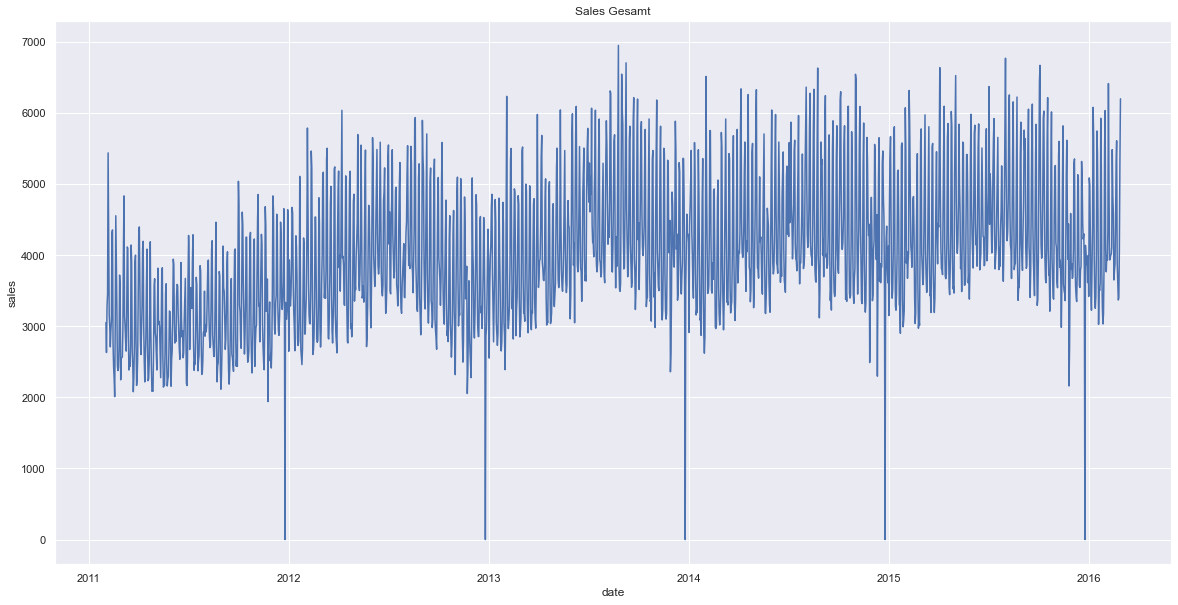

In [21]:
# Sales im Zeitverlauf
sns.lineplot(x = 'date', y = 'sales', data = data_grouped, estimator = 'mean')
plt.title('Sales Gesamt')

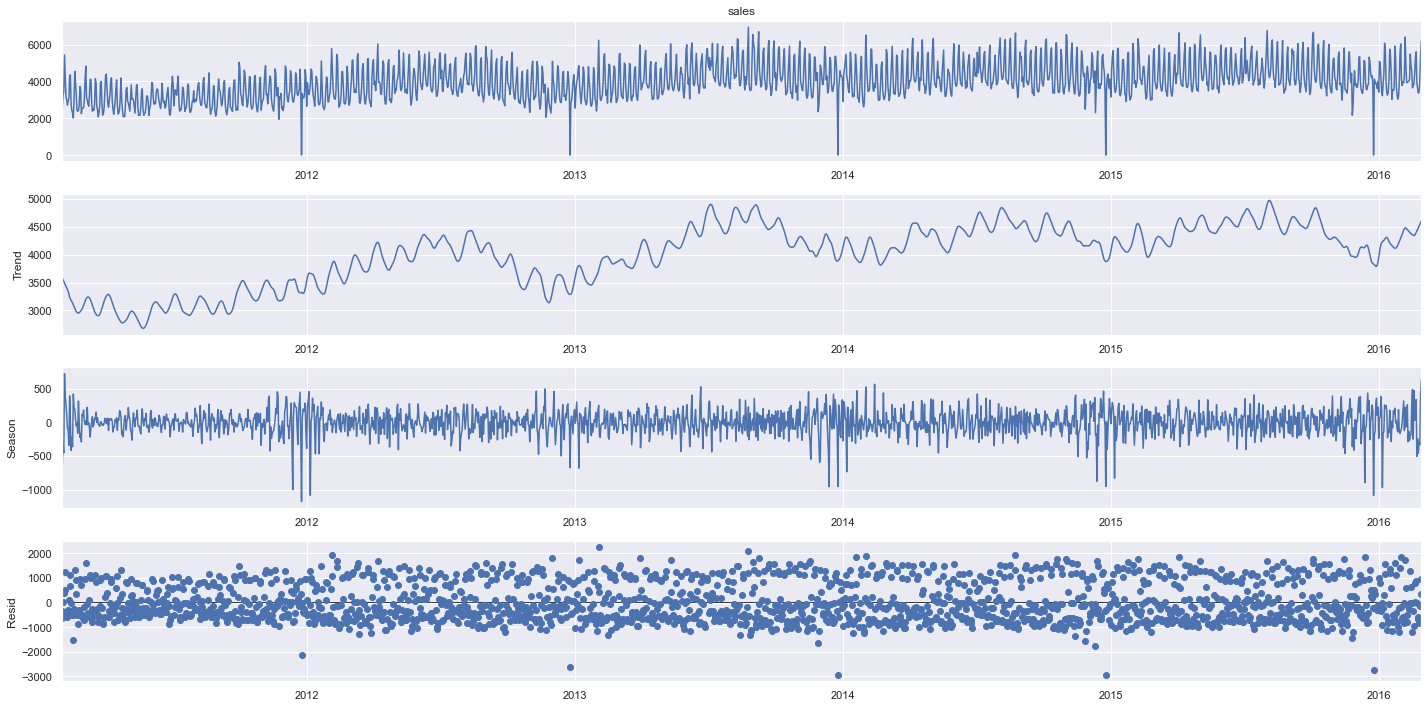

In [22]:
# Zerlegung der Sales-Zeitreihe
decompose = STL(data_grouped['sales'], period=12).fit()
decompose.plot()
plt.show()

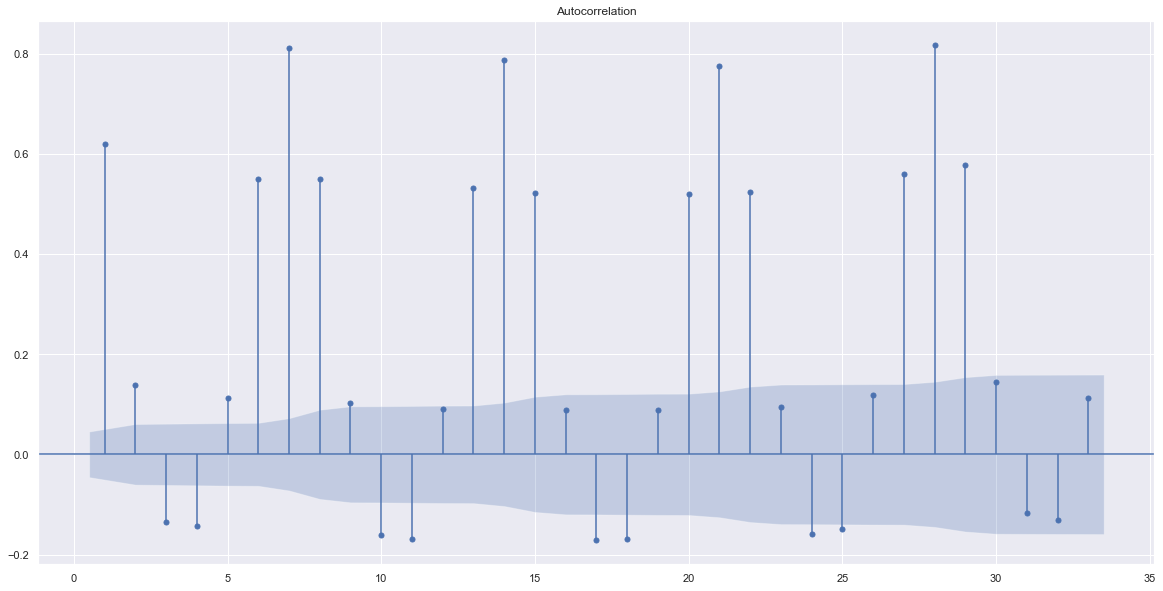

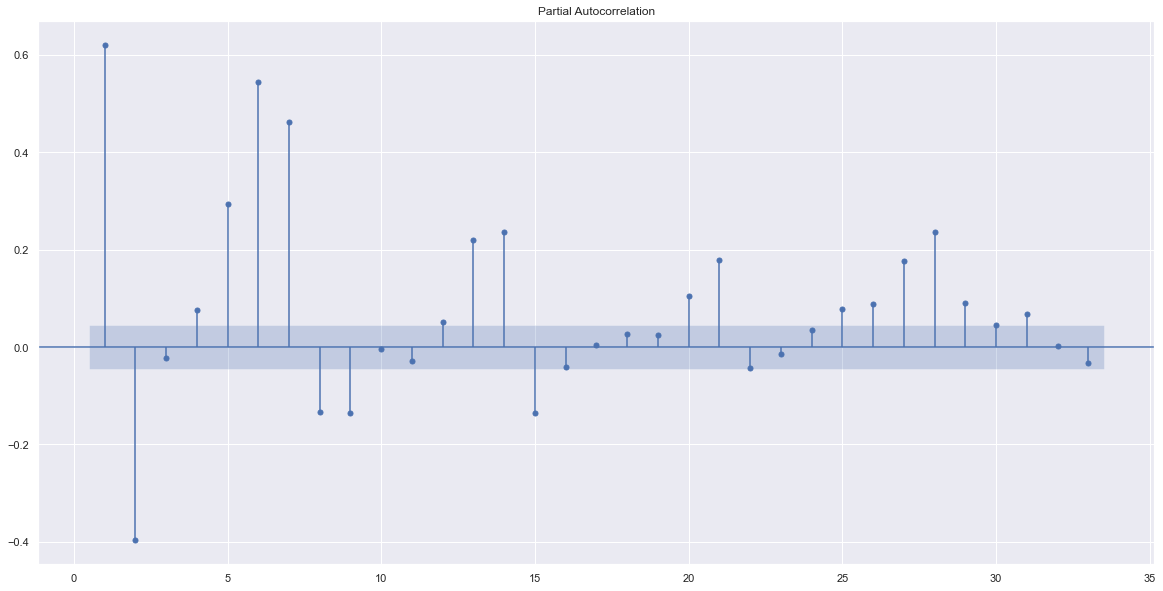

In [23]:
# Korrelogramme der Sales-Zeitreihe
plot_acf(data_grouped['sales'], zero = False)
plt.show()
plot_pacf(data_grouped['sales'], zero = False)
plt.show()

## 3. Modelling

### 3.1 Feature importance

In [54]:
# Food
# Variablen in zwei Datensätze splitten -> x = Erklärende Variablen; y = Sales
x_food = food_grouped.drop(columns = ['sales'])
y_food = food_grouped[['sales']]
k = np.floor(len(food_grouped)/30).astype(int)
cv = KFold(n_splits = k)
forecast = RandomForestRegressor(max_depth = 7)
scores = pd.DataFrame(cross_validate
                      (
                          forecast,
                          x_food,
                          y_food.values.ravel(),
                          scoring = 'neg_mean_absolute_error',
                          cv = cv,
                          verbose =1)
                     )

print('MAE mean:\t %4.2f' % (-scores['test_score'].mean()))
print('MAE mad:\t %4.2f' % (scores['test_score'].mad()))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


MAE mean:	 257.36
MAE mad:	 61.20


[Parallel(n_jobs=1)]: Done  61 out of  61 | elapsed:   34.4s finished


In [36]:
forecast.fit(x_food, y_food.values.ravel())
importance = pd.DataFrame(data = forecast.feature_importances_, index = x_food.columns)
importance.columns = ['Importance']
display(importance.sort_values(by='Importance', ascending = False))
display(x_food.shape)

Importance
Weekday_Saturday          0.287693
Weekday_Sunday            0.258088
mean_price_dept2          0.205949
snap                      0.058833
Weekday_Friday            0.042012
Weekday_Monday            0.031395
event_type_1_National     0.030332
mean_price_dept3          0.023578
mean_price_dept1          0.022354
Month_August              0.007166
Month_November            0.005968
Month_July                0.005764
Month_December            0.005236
event_type_1_Cultural     0.002605
Month_September           0.002544
Month_February            0.002460
Month_April               0.001601
Month_January             0.001458
Month_June                0.001293
Month_October             0.001176
Month_May                 0.000894
event_type_1_Sporting     0.000366
Month_March               0.000325
Weekday_Wednesday         0.000301
event_type_1_Religious    0.000256
Weekday_Thursday          0.000180
event_type_2_Cultural     0.000095
Weekday_Tuesday           0.000055
event_type_2_Religious    0.000024

(1854, 29)

In [37]:
# Automatisierte Merkmalsauswahl

k = np.floor(len(food_grouped)/30).astype(int)
cv = KFold(n_splits = k)

forecast = RandomForestRegressor(max_depth = 7)

selector = RFECV(
    forecast,
    step = 1,
    cv = cv,
    scoring = 'neg_mean_absolute_error'
)

selector = selector.fit(x_food, y_food.values.ravel())

selection = pd.DataFrame(data = selector.support_, index = x_food.columns)
selection.columns = ['Selected']
selection.index.name = 'Variable'
display(selection)

scores = pd.DataFrame(
    cross_validate(
        forecast,
        selector.transform(x_food),
        y_food.values.ravel(),
        scoring = 'neg_mean_absolute_error',
        cv = cv,
        verbose = 1
    )
)

print('MAE mean:\t %4.2f' % (-scores['test_score'].mean()))
print('MAE mad:\t %4.2f' % (scores['test_score'].mad()))

Selected
Variable                        
snap                        True
mean_price_dept1            True
mean_price_dept2            True
mean_price_dept3            True
event_type_1_Cultural       True
event_type_1_National       True
event_type_1_Religious     False
event_type_1_Sporting      False
event_type_2_Cultural      False
event_type_2_Religious     False
Month_April                 True
Month_August                True
Month_December              True
Month_February              True
Month_January               True
Month_July                  True
Month_June                  True
Month_March                False
Month_May                   True
Month_November              True
Month_October               True
Month_September             True
Weekday_Friday              True
Weekday_Monday              True
Weekday_Saturday            True
Weekday_Sunday              True
Weekday_Thursday           False
Weekday_Tuesday            False
Weekday_Wednesday          False

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


MAE mean:	 257.35
MAE mad:	 61.27


[Parallel(n_jobs=1)]: Done  61 out of  61 | elapsed:   13.8s finished


In [19]:
# Hobbies
# Variablen in zwei Datensätze splitten -> x = Erklärende Variablen; y = Sales
x_hobbies = hobbies_grouped.drop(columns = ['sales'])
y_hobbies = hobbies_grouped[['sales']]

k = np.floor(len(hobbies_grouped)/30).astype(int)
cv = KFold(n_splits = k)

#forecast = RandomForestRegressor(max_depth = 7)
forecast = LinearRegression()
scores = pd.DataFrame(cross_validate
                      (
                          forecast,
                          x_hobbies,
                          y_hobbies.values.ravel(),
                          scoring = 'neg_mean_absolute_error',
                          cv = cv,
                          verbose =1)
                     )

print('MAE mean:\t %4.2f' % (-scores['test_score'].mean()))
print('MAE mad:\t %4.2f' % (scores['test_score'].mad()))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


MAE mean:	 5892984575.85
MAE mad:	 11592756382.33


[Parallel(n_jobs=1)]: Done  61 out of  61 | elapsed:    0.6s finished


In [39]:
forecast.fit(x_hobbies, y_hobbies.values.ravel())
importance = pd.DataFrame(data = forecast.feature_importances_, index = x_hobbies.columns)
importance.columns = ['Importance']
display(importance.sort_values(by='Importance', ascending = False))
display(x_hobbies.shape)


AttributeError: 'LinearRegression' object has no attribute 'feature_importances_'

In [31]:
# Automatisierte Merkmalsauswahl

k = np.floor(len(hobbies_grouped)/30).astype(int)
cv = KFold(n_splits = k)

forecast = RandomForestRegressor(max_depth = 7)

selector = RFECV(
    forecast,
    step = 1,
    cv = cv,
    scoring = 'neg_mean_absolute_error'
)

selector = selector.fit(x_hobbies, y_hobbies.values.ravel())

selection = pd.DataFrame(data = selector.support_, index = x_hobbies.columns)
selection.columns = ['Selected']
selection.index.name = 'Variable'
display(selection)

scores = pd.DataFrame(
    cross_validate(
        forecast,
        selector.transform(x_hobbies),
        y_hobbies.values.ravel(),
        scoring = 'neg_mean_absolute_error',
        cv = cv,
        verbose = 1
    )
)

print('MAE mean:\t %4.2f' % (-scores['test_score'].mean()))
print('MAE mad:\t %4.2f' % (scores['test_score'].mad()))

KeyboardInterrupt: 

In [42]:
# Household
# Variablen in zwei Datensätze splitten -> x = Erklärende Variablen; y = Sales
x_household = household_grouped.drop(columns = ['sales'])
y_household = household_grouped[['sales']]

k = np.floor(len(household_grouped)/30).astype(int)
cv = KFold(n_splits = k)

forecast = RandomForestRegressor(max_depth = 7)

scores = pd.DataFrame(cross_validate
                      (
                          forecast,
                          x_household,
                          y_household.values.ravel(),
                          scoring = 'neg_mean_absolute_error',
                          cv = cv,
                          verbose =1)
                     )

print('MAE mean:\t %4.2f' % (-scores['test_score'].mean()))
print('MAE mad:\t %4.2f' % (scores['test_score'].mad()))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


MAE mean:	 84.76
MAE mad:	 23.71


[Parallel(n_jobs=1)]: Done  61 out of  61 | elapsed:   11.6s finished


In [43]:
forecast.fit(x_household, y_household.values.ravel())
importance = pd.DataFrame(data = forecast.feature_importances_, index = x_household.columns)
importance.columns = ['Importance']
display(importance.sort_values(by='Importance', ascending = False))
display(x_household.shape)

Importance
mean_price_dept2          0.419986
Weekday_Sunday            0.194836
Weekday_Saturday          0.189417
mean_price_dept1          0.110111
Weekday_Friday            0.018481
Weekday_Monday            0.018390
event_type_1_National     0.017988
event_type_1_Cultural     0.007153
Month_December            0.004918
Month_July                0.004325
Month_August              0.003518
Month_January             0.001873
Month_March               0.001562
Month_May                 0.001270
event_type_1_Sporting     0.001091
Month_September           0.001035
Month_November            0.000989
Month_February            0.000848
Weekday_Wednesday         0.000532
Month_June                0.000525
Weekday_Thursday          0.000397
Month_October             0.000267
event_type_1_Religious    0.000198
Month_April               0.000142
Weekday_Tuesday           0.000074
event_type_2_Cultural     0.000042
event_type_2_Religious    0.000032

(1854, 27)

In [44]:
# Automatisierte Merkmalsauswahl

k = np.floor(len(household_grouped)/30).astype(int)
cv = KFold(n_splits = k)

forecast = RandomForestRegressor(max_depth = 7)

selector = RFECV(
    forecast,
    step = 1,
    cv = cv,
    scoring = 'neg_mean_absolute_error'
)

selector = selector.fit(x_household, y_household.values.ravel())

selection = pd.DataFrame(data = selector.support_, index = x_household.columns)
selection.columns = ['Selected']
selection.index.name = 'Variable'
display(selection)

scores = pd.DataFrame(
    cross_validate(
        forecast,
        selector.transform(x_household),
        y_household.values.ravel(),
        scoring = 'neg_mean_absolute_error',
        cv = cv,
        verbose = 1
    )
)

print('MAE mean:\t %4.2f' % (-scores['test_score'].mean()))
print('MAE mad:\t %4.2f' % (scores['test_score'].mad()))

Selected
Variable                        
mean_price_dept1            True
mean_price_dept2            True
event_type_1_Cultural       True
event_type_1_National       True
event_type_1_Religious     False
event_type_1_Sporting      False
event_type_2_Cultural      False
event_type_2_Religious     False
Month_April                False
Month_August                True
Month_December              True
Month_February             False
Month_January               True
Month_July                  True
Month_June                 False
Month_March                 True
Month_May                  False
Month_November             False
Month_October              False
Month_September             True
Weekday_Friday              True
Weekday_Monday              True
Weekday_Saturday            True
Weekday_Sunday              True
Weekday_Thursday           False
Weekday_Tuesday            False
Weekday_Wednesday          False

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


MAE mean:	 84.42
MAE mad:	 23.65


[Parallel(n_jobs=1)]: Done  61 out of  61 | elapsed:   11.3s finished


### 3.2 Einfache Verfahren

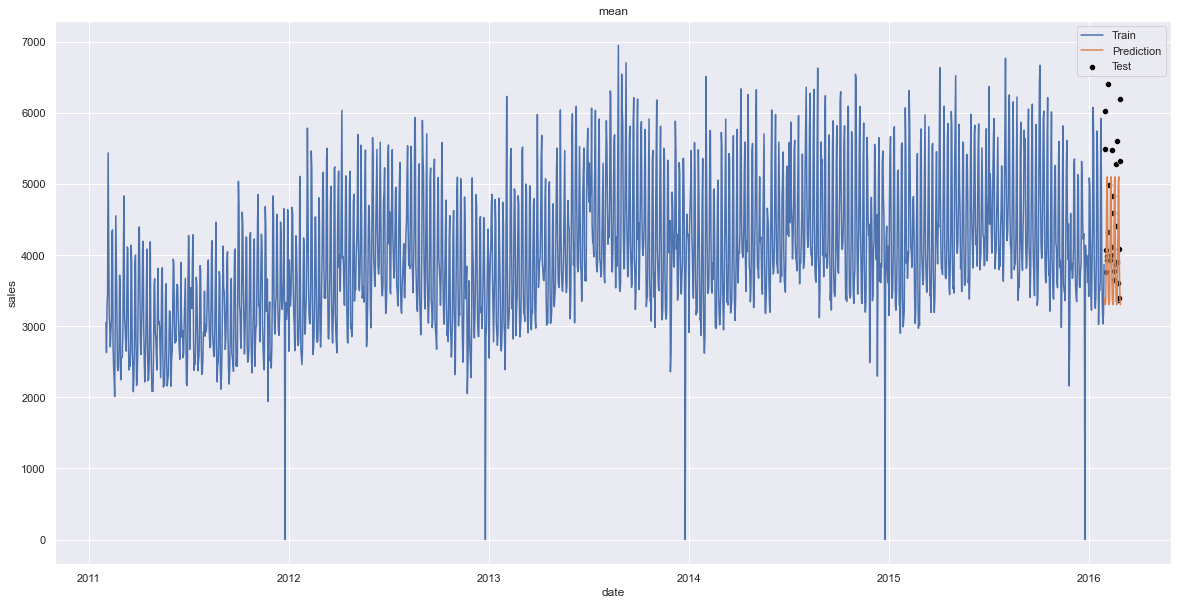

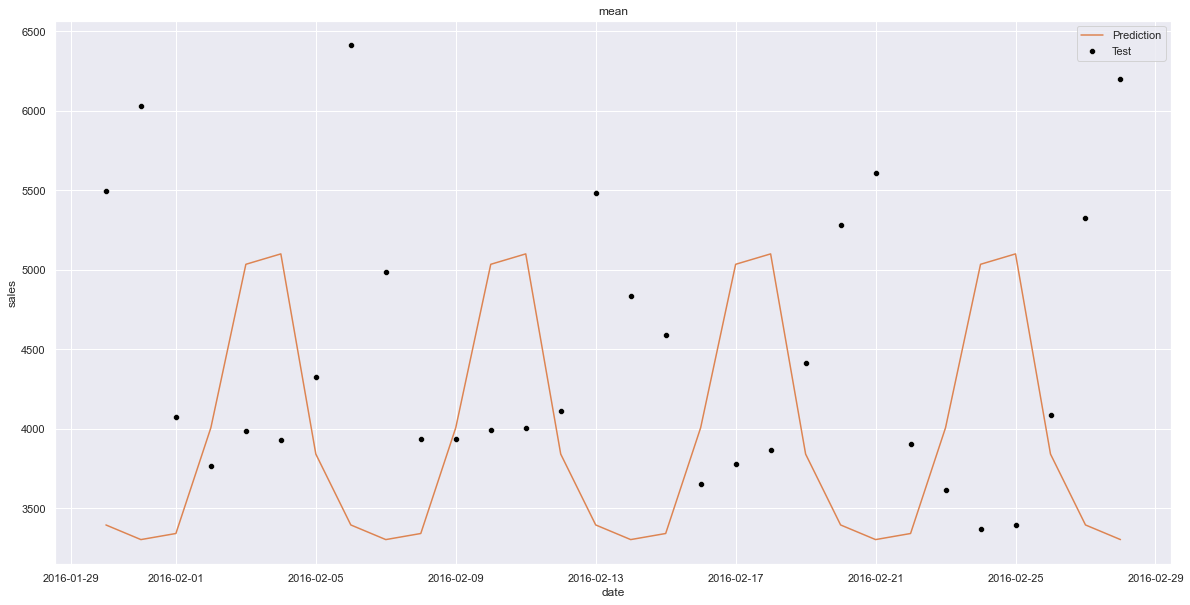

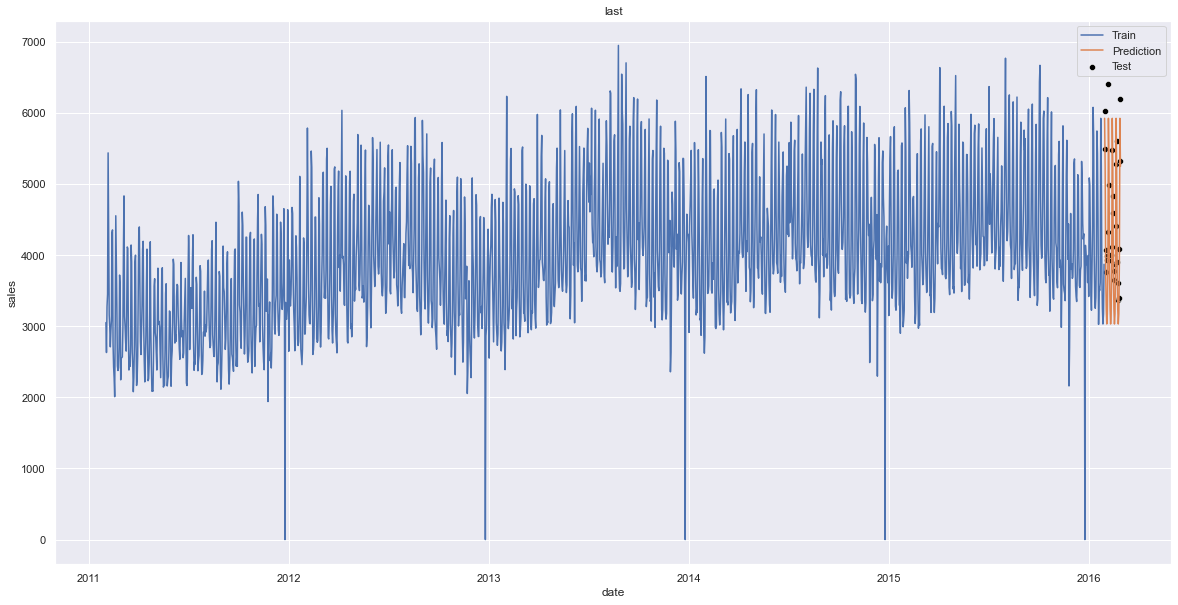

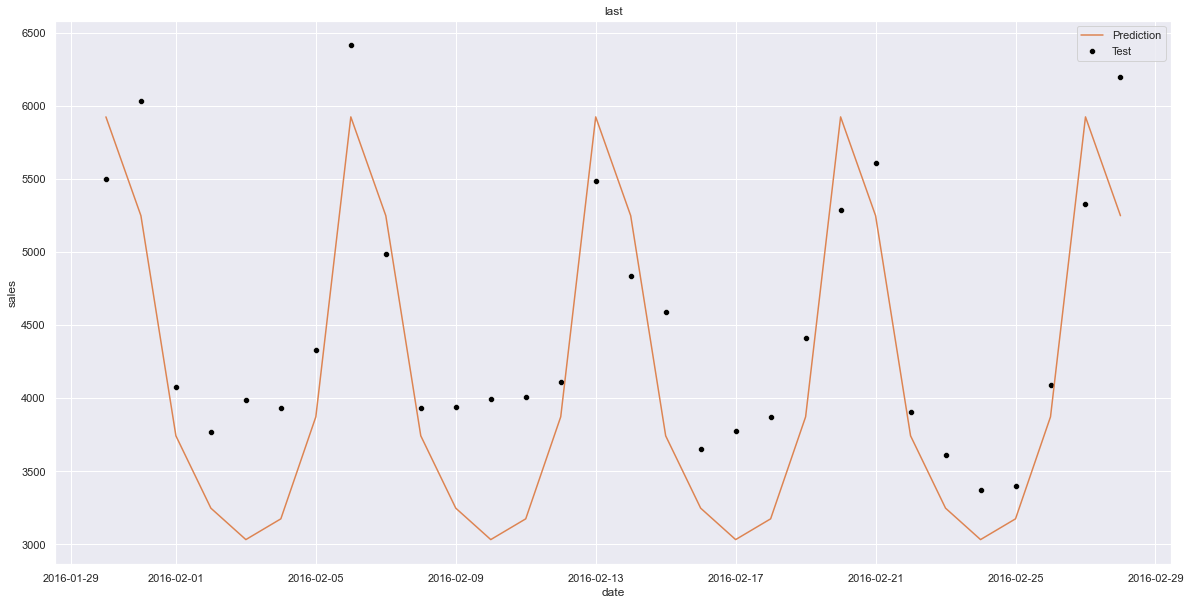

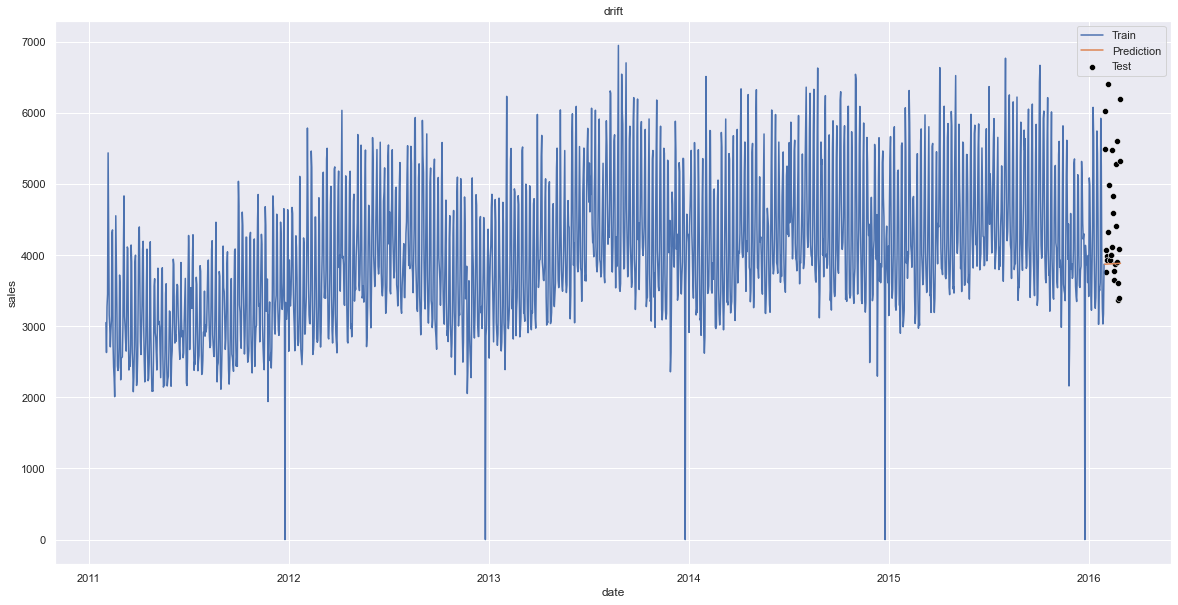

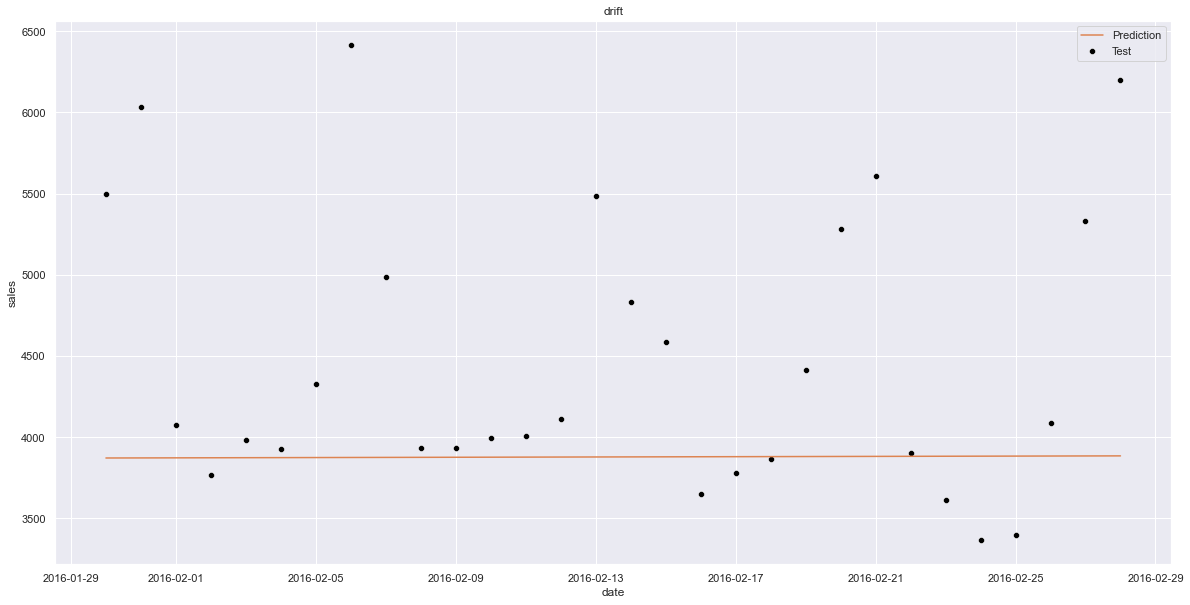

In [45]:
train, test = temporal_train_test_split(data_grouped, test_size = 30)

train.index.freq = 'D'
test.index.freq = 'D'
fh = ForecastingHorizon(test.index, is_relative = False)

for strategy in ['mean', 'last', 'drift']:
    if strategy == 'drift':
        forecast = NaiveForecaster(strategy = strategy)
    else:
        forecast = NaiveForecaster(strategy = strategy, sp = 7)
    forecast.fit(train['sales'])
    
    sns.lineplot(data = train['sales'], label = 'Train')
    sns.scatterplot(data = test['sales'], color = 'black', label = 'Test')
    sns.lineplot(data = forecast.predict(fh), label = 'Prediction')
    plt.title(strategy)
    plt.show()
    
    sns.scatterplot(data = test['sales'], color = 'black', label = 'Test')
    sns.lineplot(data = forecast.predict(fh), color = sns.color_palette('deep').as_hex()[1], label = 'Prediction')
    plt.title(strategy)
    plt.show()

### 3.3 Lineare Regression

C:\Users\royaa\AppData\Roaming\Python\Python37\site-packages\sktime\forecasting\base\_fh.py:451: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  if not hasattr(cutoff, "freqstr") or cutoff.freqstr is None:
C:\Users\royaa\AppData\Roaming\Python\Python37\site-packages\sktime\forecasting\base\_fh.py:461: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  assert cutoff.freqstr == index.freqstr
C:\Users\royaa\AppData\Roaming\Python\Python37\site-packages\sktime\utils\datetime.py:55: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  if hasattr(x, "freqstr"):
C:\Users\royaa\AppData\Roaming\Python\Python37\site-packages\sktime\utils\datetime.py:56: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  return x.freqstr
C:\Users\royaa\AppData\Roaming\Python\Python37\site-packages\sktime\utils\datetime.py:78: FutureWarning: Timestamp.freq is 

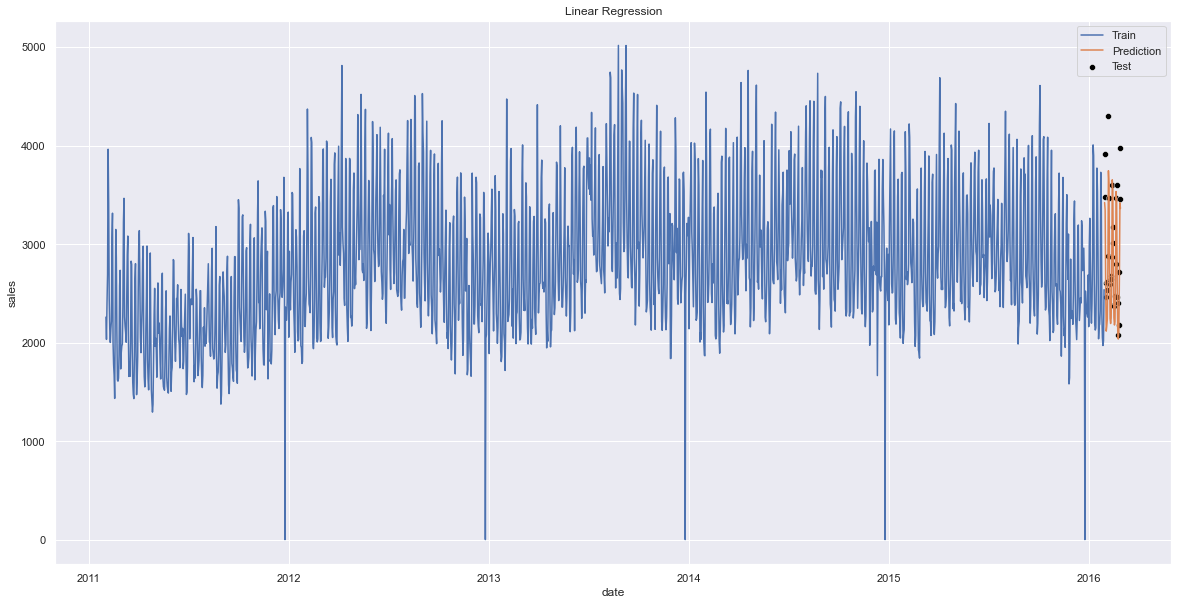

C:\Users\royaa\AppData\Roaming\Python\Python37\site-packages\sktime\utils\datetime.py:78: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  if not hasattr(x, "freq") or x.freq is None:
C:\Users\royaa\AppData\Roaming\Python\Python37\site-packages\sktime\utils\datetime.py:80: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  by *= x.freq
C:\Users\royaa\AppData\Roaming\Python\Python37\site-packages\sktime\forecasting\base\_fh.py:451: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  if not hasattr(cutoff, "freqstr") or cutoff.freqstr is None:
C:\Users\royaa\AppData\Roaming\Python\Python37\site-packages\sktime\forecasting\base\_fh.py:461: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  assert cutoff.freqstr == index.freqstr
C:\Users\royaa\AppData\Roaming\Python\Python37\site-packages\sktime\utils\datetime.py:55: FutureWarning: Timestamp.f

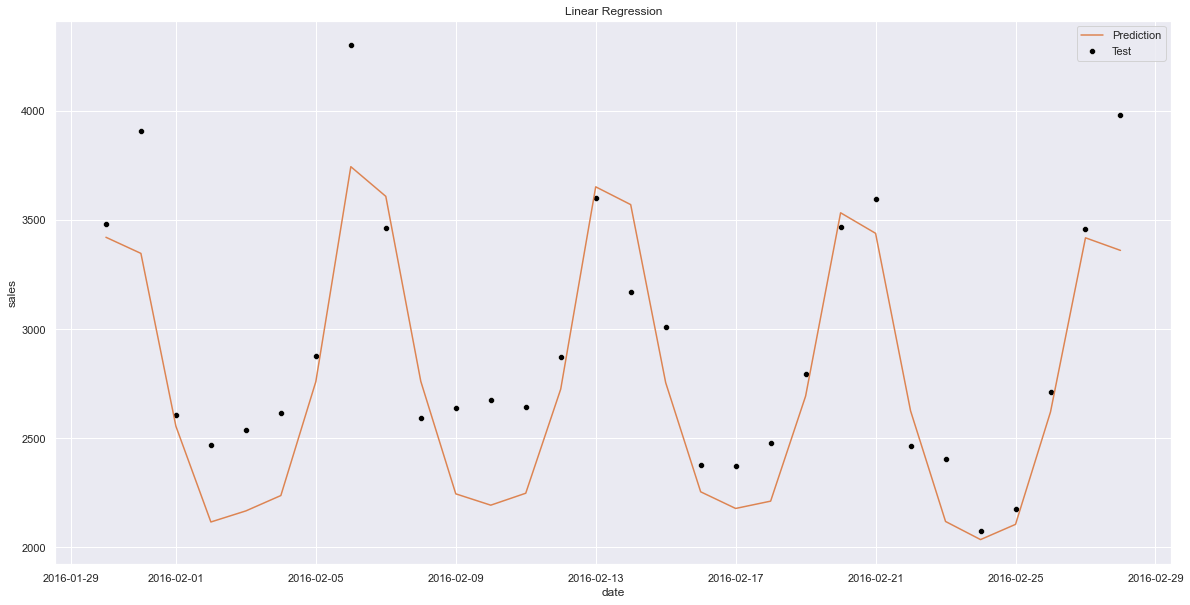

RMSE:	 15.39


C:\Users\royaa\AppData\Roaming\Python\Python37\site-packages\sktime\utils\datetime.py:78: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  if not hasattr(x, "freq") or x.freq is None:
C:\Users\royaa\AppData\Roaming\Python\Python37\site-packages\sktime\utils\datetime.py:80: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  by *= x.freq
C:\Users\royaa\AppData\Roaming\Python\Python37\site-packages\sktime\forecasting\base\_fh.py:451: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  if not hasattr(cutoff, "freqstr") or cutoff.freqstr is None:
C:\Users\royaa\AppData\Roaming\Python\Python37\site-packages\sktime\forecasting\base\_fh.py:461: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  assert cutoff.freqstr == index.freqstr
C:\Users\royaa\AppData\Roaming\Python\Python37\site-packages\sktime\utils\datetime.py:55: FutureWarning: Timestamp.f

sales
date                   
2016-01-30  3420.759821
2016-01-31  3346.864198
2016-02-01  2554.892832
2016-02-02  2116.014278
2016-02-03  2166.737906

In [81]:
#Modellierung Food

train_food, test_food = temporal_train_test_split(food_grouped, test_size = 30)

train_food.index.freq = 'D'
test_food.index.freq = 'D'
fh = ForecastingHorizon(test_food.index, is_relative = False)

reg = LinearRegression()
forecast = make_reduction(reg, window_length = 30, strategy = "recursive")

forecast.fit(train_food['sales'])
   
sns.lineplot(data = train_food['sales'], label = 'Train')
sns.scatterplot(data = test_food['sales'], color = 'black', label = 'Test')
sns.lineplot(data = forecast.predict(fh), label = 'Prediction')
plt.title('Linear Regression')
plt.show()

sns.scatterplot(data = test_food['sales'], color = 'black', label = 'Test')
sns.lineplot(data = forecast.predict(fh), color = sns.color_palette('deep').as_hex()[1], label = 'Prediction')
plt.title('Linear Regression')
plt.show()

LinReg_MSE_Food = MSE(y_true = test_food['sales'], y_pred = forecast.predict(fh))
LinReg_RMSE_Food = sqrt(LinReg_MSE_Food)
print('RMSE:\t %4.2f' % LinReg_RMSE_Food)

#Prognostizierte Werte pro Kategorie in Tabelle schreiben
prediction_food = pd.DataFrame(data = forecast.predict(fh), index = pd.date_range(start = test_food.index.min(), end = test_food.index.max()))
prediction_food.index.name = 'date'
prediction_food.columns = ['sales']
prediction_food[prediction_food.sales < 0] = 0
display(prediction_food.head())

In [70]:
#Cross Validation Food ###überarbeiten!!!

k = np.floor(len(food_grouped)/30).astype(int)
# k = len(data)

cv = KFold(n_splits = k)
#cv = TimeSeriesSplit(n_splits = 10, max_train_size = None, test_size = 28, gap = 0)

x = food_grouped.drop(columns = ['sales'])
y = food_grouped[['sales']]

forecast = LinearRegression()
scores = pd.DataFrame(
    cross_validate(
        forecast,
        x,
        y,
        scoring = ['neg_mean_absolute_error', 'neg_root_mean_squared_error'],
        cv = cv,
        verbose = 1
    )
)
display(scores)

print('MAE mean:\t %4.2f' % (-scores['test_neg_mean_absolute_error'].mean()))
print('RMSE mean:\t %4.2f' % (-scores['test_neg_root_mean_squared_error'].mean()))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  61 out of  61 | elapsed:    0.7s finished


fit_time  score_time  test_neg_mean_absolute_error  \
0   0.022128    0.000000                   -415.532258   
1   0.000000    0.015632                   -161.387097   
2   0.015617    0.000000                   -206.322581   
3   0.015624    0.015622                   -229.225806   
4   0.015619    0.000000                   -343.935484   
..       ...         ...                           ...   
56  0.000000    0.000000                   -208.333333   
57  0.015622    0.000000                   -362.733333   
58  0.000000    0.015620                   -452.566667   
59  0.000000    0.000000                   -273.662500   
60  0.015623    0.000000                   -176.983333   

    test_neg_root_mean_squared_error  
0                        -517.240296  
1                        -206.694180  
2                        -243.926880  
3                        -308.090058  
4                        -407.790190  
..                               ...  
56                       -266.738199  
57                       -457.413963  
58                       -652.843703  
59                       -338.098308  
60                       -237.508851  

[61 rows x 4 columns]

MAE mean:	 1887255219037.61
RMSE mean:	 10336922551213.54


C:\Users\royaa\AppData\Roaming\Python\Python37\site-packages\sktime\forecasting\base\_fh.py:451: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  if not hasattr(cutoff, "freqstr") or cutoff.freqstr is None:
C:\Users\royaa\AppData\Roaming\Python\Python37\site-packages\sktime\forecasting\base\_fh.py:461: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  assert cutoff.freqstr == index.freqstr
C:\Users\royaa\AppData\Roaming\Python\Python37\site-packages\sktime\utils\datetime.py:55: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  if hasattr(x, "freqstr"):
C:\Users\royaa\AppData\Roaming\Python\Python37\site-packages\sktime\utils\datetime.py:56: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  return x.freqstr
C:\Users\royaa\AppData\Roaming\Python\Python37\site-packages\sktime\utils\datetime.py:78: FutureWarning: Timestamp.freq is 

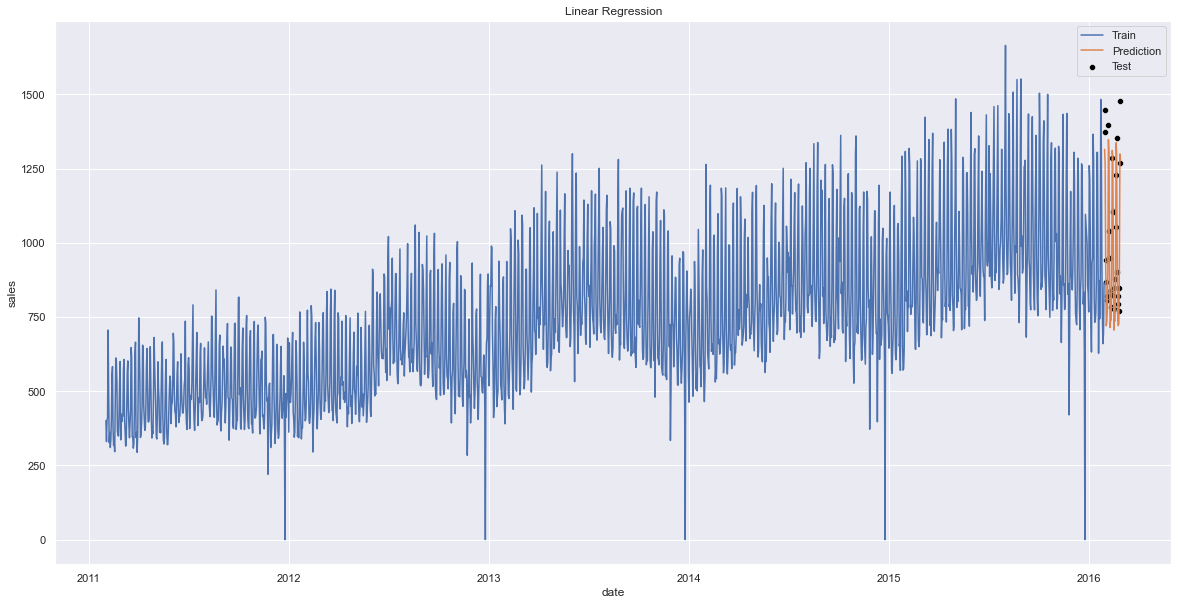

C:\Users\royaa\AppData\Roaming\Python\Python37\site-packages\sktime\utils\datetime.py:78: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  if not hasattr(x, "freq") or x.freq is None:
C:\Users\royaa\AppData\Roaming\Python\Python37\site-packages\sktime\utils\datetime.py:80: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  by *= x.freq
C:\Users\royaa\AppData\Roaming\Python\Python37\site-packages\sktime\forecasting\base\_fh.py:451: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  if not hasattr(cutoff, "freqstr") or cutoff.freqstr is None:
C:\Users\royaa\AppData\Roaming\Python\Python37\site-packages\sktime\forecasting\base\_fh.py:461: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  assert cutoff.freqstr == index.freqstr
C:\Users\royaa\AppData\Roaming\Python\Python37\site-packages\sktime\utils\datetime.py:55: FutureWarning: Timestamp.f

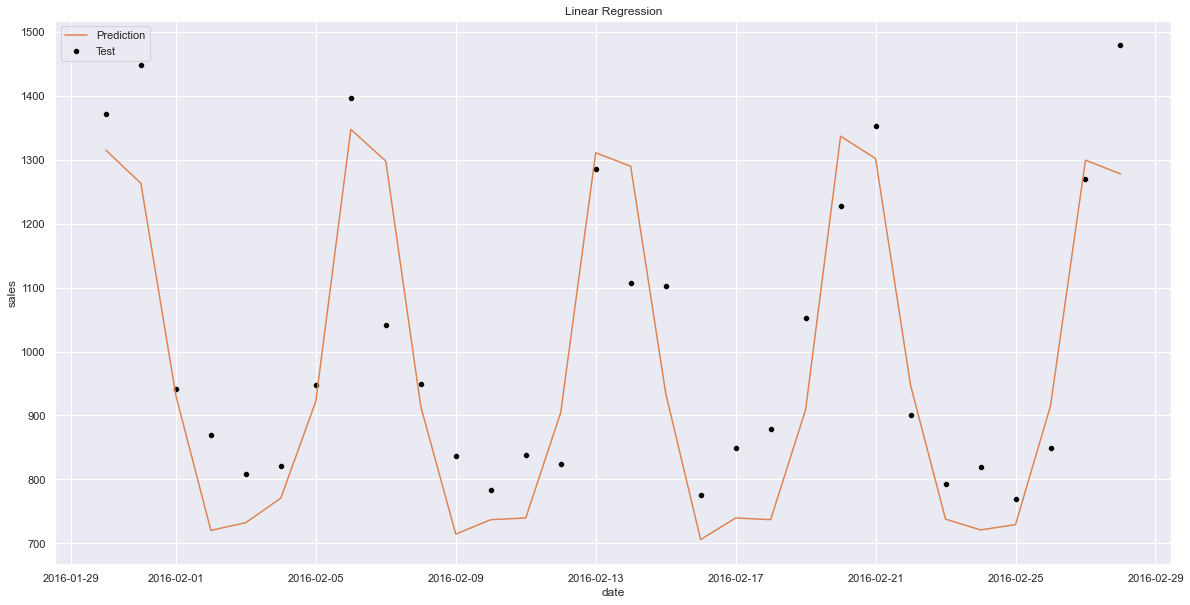

RMSE:	 9.63


C:\Users\royaa\AppData\Roaming\Python\Python37\site-packages\sktime\utils\datetime.py:78: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  if not hasattr(x, "freq") or x.freq is None:
C:\Users\royaa\AppData\Roaming\Python\Python37\site-packages\sktime\utils\datetime.py:80: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  by *= x.freq
C:\Users\royaa\AppData\Roaming\Python\Python37\site-packages\sktime\forecasting\base\_fh.py:451: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  if not hasattr(cutoff, "freqstr") or cutoff.freqstr is None:
C:\Users\royaa\AppData\Roaming\Python\Python37\site-packages\sktime\forecasting\base\_fh.py:461: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  assert cutoff.freqstr == index.freqstr
C:\Users\royaa\AppData\Roaming\Python\Python37\site-packages\sktime\utils\datetime.py:55: FutureWarning: Timestamp.f

sales
date                   
2016-01-30  1314.981915
2016-01-31  1263.187707
2016-02-01   931.027933
2016-02-02   720.103970
2016-02-03   732.247509

In [83]:
#Modellierung Household

train_household, test_household = temporal_train_test_split(household_grouped, test_size = 30)

train_household.index.freq = 'D'
test_household.index.freq = 'D'
fh = ForecastingHorizon(test_household.index, is_relative = False)

reg = LinearRegression()
forecast = make_reduction(reg, window_length = 30, strategy = "recursive")

forecast.fit(train_household['sales'])
   
sns.lineplot(data = train_household['sales'], label = 'Train')
sns.scatterplot(data = test_household['sales'], color = 'black', label = 'Test')
sns.lineplot(data = forecast.predict(fh), label = 'Prediction')
plt.title('Linear Regression')
plt.show()

sns.scatterplot(data = test_household['sales'], color = 'black', label = 'Test')
sns.lineplot(data = forecast.predict(fh), color = sns.color_palette('deep').as_hex()[1], label = 'Prediction')
plt.title('Linear Regression')
plt.show()

LinReg_MSE_Household = MSE(y_true = test_household['sales'], y_pred = forecast.predict(fh))
LinReg_RMSE_Household = sqrt(LinReg_MSE_Household)
print('RMSE:\t %4.2f' % LinReg_RMSE_Household)

#Prognostizierte Werte pro Kategorie in Tabelle schreiben
prediction_household = pd.DataFrame(data = forecast.predict(fh), index = pd.date_range(start = test_household.index.min(), end = test_household.index.max()))
prediction_household.index.name = 'date'
prediction_household.columns = ['sales']
prediction_household[prediction_household.sales < 0] = 0
display(prediction_household.head())

In [71]:
#Cross Validation Household ###überarbeiten!!!

k = np.floor(len(household_grouped)/30).astype(int)
# k = len(data)

cv = KFold(n_splits = k)
#cv = TimeSeriesSplit(n_splits = 10, max_train_size = None, test_size = 28, gap = 0)

x = household_grouped.drop(columns = ['sales'])
y = household_grouped[['sales']]

forecast = LinearRegression()
scores = pd.DataFrame(
    cross_validate(
        forecast,
        x,
        y,
        scoring = ['neg_mean_absolute_error', 'neg_root_mean_squared_error'],
        cv = cv,
        verbose = 1
    )
)
display(scores)

print('MAE mean:\t %4.2f' % (-scores['test_neg_mean_absolute_error'].mean()))
print('RMSE mean:\t %4.2f' % (-scores['test_neg_root_mean_squared_error'].mean()))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  61 out of  61 | elapsed:    0.6s finished


fit_time  score_time  test_neg_mean_absolute_error  \
0   0.015620    0.000000                   -103.838710   
1   0.015624    0.000000                    -86.580645   
2   0.015619    0.000000                    -61.596774   
3   0.000000    0.015627                    -87.419355   
4   0.015637    0.006514                   -107.209677   
..       ...         ...                           ...   
56  0.000000    0.000000                   -110.966667   
57  0.015624    0.000000                   -115.233333   
58  0.000000    0.015620                   -137.367708   
59  0.000000    0.000000                   -110.266667   
60  0.015623    0.006508                   -102.091667   

    test_neg_root_mean_squared_error  
0                        -125.496241  
1                        -102.987315  
2                         -78.628362  
3                        -105.413472  
4                        -133.097012  
..                               ...  
56                       -145.820552  
57                       -144.565441  
58                       -197.646132  
59                       -148.173252  
60                       -136.748438  

[61 rows x 4 columns]

MAE mean:	 1073568157741.96
RMSE mean:	 5880174969758.30


C:\Users\royaa\AppData\Roaming\Python\Python37\site-packages\sktime\forecasting\base\_fh.py:451: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  if not hasattr(cutoff, "freqstr") or cutoff.freqstr is None:
C:\Users\royaa\AppData\Roaming\Python\Python37\site-packages\sktime\forecasting\base\_fh.py:461: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  assert cutoff.freqstr == index.freqstr
C:\Users\royaa\AppData\Roaming\Python\Python37\site-packages\sktime\utils\datetime.py:55: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  if hasattr(x, "freqstr"):
C:\Users\royaa\AppData\Roaming\Python\Python37\site-packages\sktime\utils\datetime.py:56: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  return x.freqstr
C:\Users\royaa\AppData\Roaming\Python\Python37\site-packages\sktime\utils\datetime.py:78: FutureWarning: Timestamp.freq is 

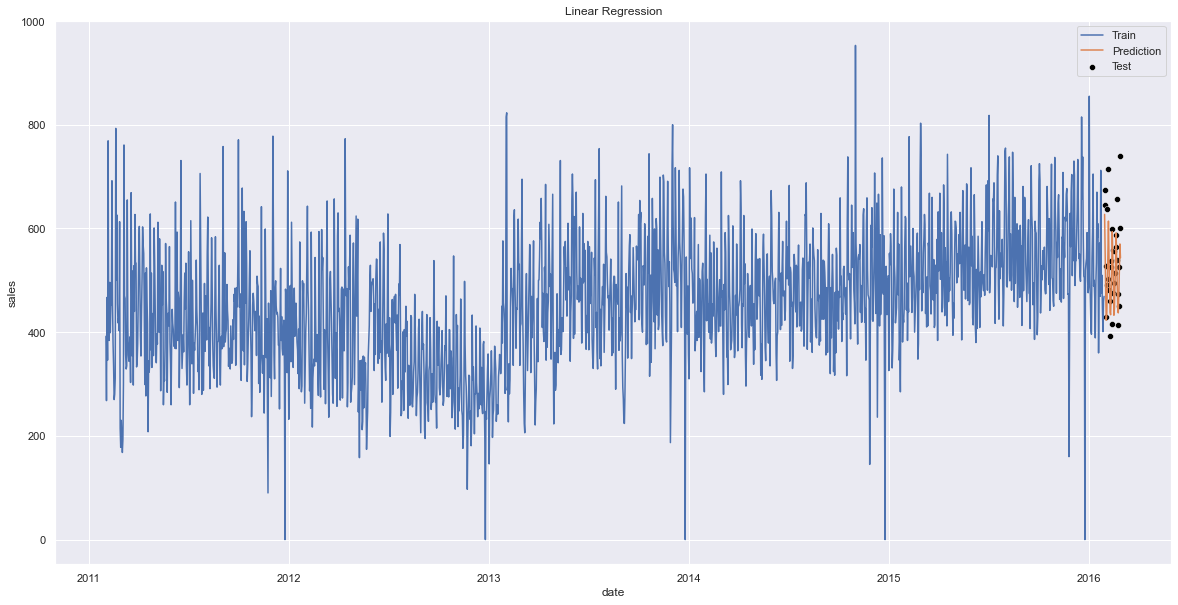

C:\Users\royaa\AppData\Roaming\Python\Python37\site-packages\sktime\utils\datetime.py:78: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  if not hasattr(x, "freq") or x.freq is None:
C:\Users\royaa\AppData\Roaming\Python\Python37\site-packages\sktime\utils\datetime.py:80: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  by *= x.freq
C:\Users\royaa\AppData\Roaming\Python\Python37\site-packages\sktime\forecasting\base\_fh.py:451: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  if not hasattr(cutoff, "freqstr") or cutoff.freqstr is None:
C:\Users\royaa\AppData\Roaming\Python\Python37\site-packages\sktime\forecasting\base\_fh.py:461: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  assert cutoff.freqstr == index.freqstr
C:\Users\royaa\AppData\Roaming\Python\Python37\site-packages\sktime\utils\datetime.py:55: FutureWarning: Timestamp.f

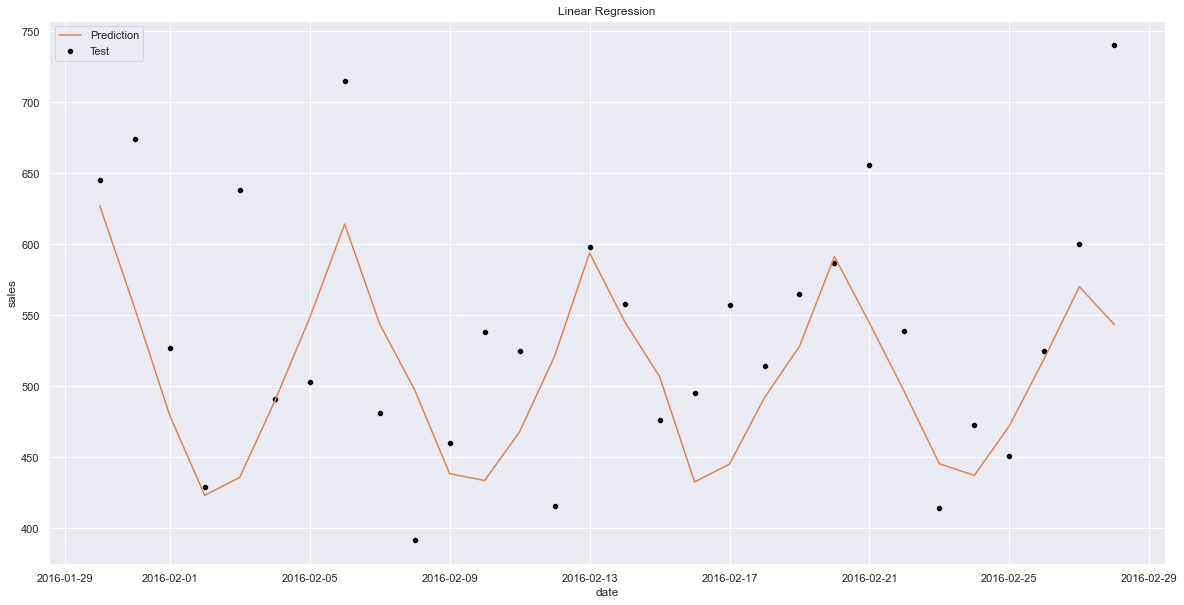

RMSE:	 7.65


C:\Users\royaa\AppData\Roaming\Python\Python37\site-packages\sktime\utils\datetime.py:78: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  if not hasattr(x, "freq") or x.freq is None:
C:\Users\royaa\AppData\Roaming\Python\Python37\site-packages\sktime\utils\datetime.py:80: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  by *= x.freq
C:\Users\royaa\AppData\Roaming\Python\Python37\site-packages\sktime\forecasting\base\_fh.py:451: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  if not hasattr(cutoff, "freqstr") or cutoff.freqstr is None:
C:\Users\royaa\AppData\Roaming\Python\Python37\site-packages\sktime\forecasting\base\_fh.py:461: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  assert cutoff.freqstr == index.freqstr
C:\Users\royaa\AppData\Roaming\Python\Python37\site-packages\sktime\utils\datetime.py:55: FutureWarning: Timestamp.f

sales
date                  
2016-01-30  627.125798
2016-01-31  554.840591
2016-02-01  479.421116
2016-02-02  423.135303
2016-02-03  435.805635

In [84]:
#Modellierung Hobbies

train_hobbies, test_hobbies = temporal_train_test_split(hobbies_grouped, test_size = 30)

train_hobbies.index.freq = 'D'
test_hobbies.index.freq = 'D'
fh = ForecastingHorizon(test_hobbies.index, is_relative = False)

reg = LinearRegression()
forecast = make_reduction(reg, window_length = 30, strategy = "recursive")

forecast.fit(train_hobbies['sales'])
   
sns.lineplot(data = train_hobbies['sales'], label = 'Train')
sns.scatterplot(data = test_hobbies['sales'], color = 'black', label = 'Test')
sns.lineplot(data = forecast.predict(fh), label = 'Prediction')
plt.title('Linear Regression')
plt.show()

sns.scatterplot(data = test_hobbies['sales'], color = 'black', label = 'Test')
sns.lineplot(data = forecast.predict(fh), color = sns.color_palette('deep').as_hex()[1], label = 'Prediction')
plt.title('Linear Regression')
plt.show()

LinReg_MSE_Hobbies = MSE(y_true = test_hobbies['sales'], y_pred = forecast.predict(fh))
LinReg_RMSE_Hobbies = sqrt(LinReg_MSE_Hobbies)
print('RMSE:\t %4.2f' % LinReg_RMSE_Hobbies)

#Prognostizierte Werte pro Kategorie in Tabelle schreiben
prediction_hobbies = pd.DataFrame(data = forecast.predict(fh), index = pd.date_range(start = test_hobbies.index.min(), end = test_hobbies.index.max()))
prediction_hobbies.index.name = 'date'
prediction_hobbies.columns = ['sales']
prediction_hobbies[prediction_hobbies.sales < 0] = 0
display(prediction_hobbies.head())


In [79]:
#Cross Validation Hobbies ###überarbeiten!!!

k = np.floor(len(hobbies_grouped)/30).astype(int)
# k = len(data)

cv = KFold(n_splits = k)
#cv = TimeSeriesSplit(n_splits = 10, max_train_size = None, test_size = 28, gap = 0)

x = hobbies_grouped.drop(columns = ['sales'])
y = hobbies_grouped[['sales']]

forecast = LinearRegression()

scores = pd.DataFrame(
    cross_validate(
        forecast,
        x,
        y,
        scoring = ['neg_mean_absolute_error', 'neg_root_mean_squared_error'],
        cv = cv,
        verbose = 1
    )
)
#display(scores)

print('MAE mean:\t %4.2f' % (-scores['test_neg_mean_absolute_error'].mean()))
print('RMSE mean:\t %4.2f' % (-scores['test_neg_root_mean_squared_error'].mean()))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


MAE mean:	 5892984575.85
RMSE mean:	 32277205487.28


[Parallel(n_jobs=1)]: Done  61 out of  61 | elapsed:    0.7s finished


sales_food  sales_hobbies  sales_household   Total
date                                                          
2011-02-01      2258.0          392.0            401.0  3051.0
2011-02-02      2032.0          268.0            330.0  2630.0
2011-02-03      2407.0          467.0            402.0  3276.0
2011-02-04      2693.0          346.0            411.0  3450.0
2011-02-05      3962.0          769.0            706.0  5437.0

sales_food  sales_hobbies  sales_household        Total
date                                                                
2016-01-30  3420.759821     627.125798      1314.981915  5362.867533
2016-01-31  3346.864198     554.840591      1263.187707  5164.892496
2016-02-01  2554.892832     479.421116       931.027933  3965.341882
2016-02-02  2116.014278     423.135303       720.103970  3259.253551
2016-02-03  2166.737906     435.805635       732.247509  3334.791049

sales_food  sales_hobbies  sales_household        Total
date                                                                
2011-02-01  2258.000000     392.000000       401.000000  3051.000000
2011-02-02  2032.000000     268.000000       330.000000  2630.000000
2011-02-03  2407.000000     467.000000       402.000000  3276.000000
2011-02-04  2693.000000     346.000000       411.000000  3450.000000
2011-02-05  3962.000000     769.000000       706.000000  5437.000000
...                 ...            ...              ...          ...
2016-02-24  2035.309442     437.210525       720.840352  3193.360319
2016-02-25  2105.103443     472.166035       729.195806  3306.465283
2016-02-26  2620.269632     519.617960       914.857313  4054.744906
2016-02-27  3418.281836     570.112192      1299.452225  5287.846253
2016-02-28  3360.572023     543.400520      1277.924755  5181.897299

[1854 rows x 4 columns]

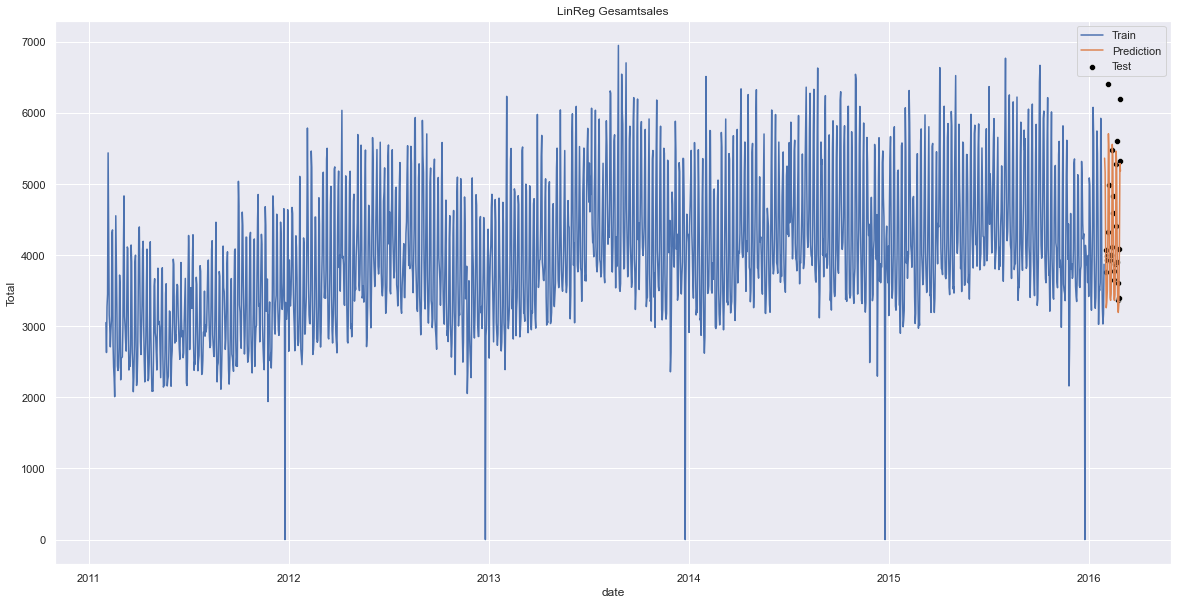

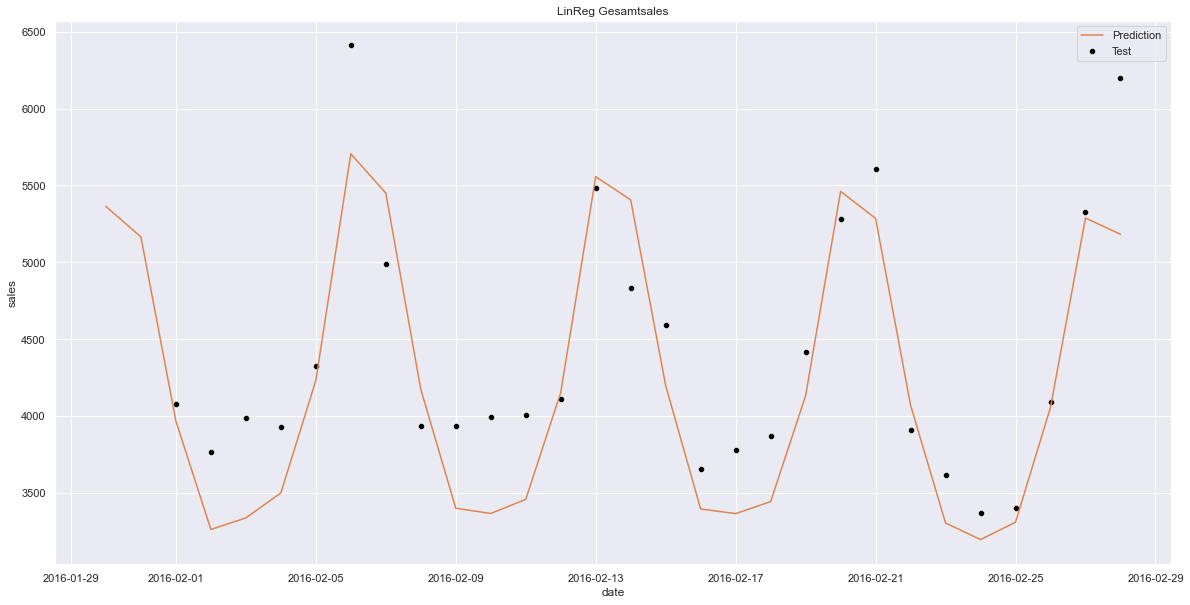

In [88]:
#Aggregation aller Modelle Lineare Regression
# Trainingdaten
lr_train_agg = pd.merge(train_food['sales'], train_hobbies['sales'], on= "date")
lr_train_agg = pd.merge(lr_train_agg, train_household['sales'], on='date')
lr_train_agg['Total'] = lr_train_agg.sum(axis=1)
lr_train_agg = lr_train_agg.rename(columns={"sales_x":"sales_food","sales_y":"sales_hobbies","sales":"sales_household"})
lr_train_agg = pd.DataFrame(lr_train_agg)
lr_train_agg.sort_values(by='date', inplace=True, ignore_index=False)
display(lr_train_agg.head())



# Testdaten
lr_test_agg = pd.merge(prediction_food['sales'], prediction_hobbies['sales'], on= "date")
lr_test_agg = pd.merge(lr_test_agg, prediction_household['sales'], on='date')
lr_test_agg['Total'] = lr_test_agg.sum(axis=1)
lr_test_agg = lr_test_agg.rename(columns={"sales_x":"sales_food","sales_y":"sales_hobbies","sales":"sales_household"})
lr_test_agg = pd.DataFrame(lr_test_agg)
lr_test_agg.sort_values(by='date', inplace=True, ignore_index=False)
display(lr_test_agg.head())


#Trainings- und Testdaten zusammenfügen
lr_total_agg = lr_train_agg.append(lr_test_agg)
display(lr_total_agg)

# Visualisierung gesamt
data_february = data_grouped.loc['2016-02-01':'2016-02-29']

sns.lineplot(data = lr_train_agg['Total'], label = 'Train')
sns.scatterplot(data = data_february['sales'], color = 'black', label = 'Test')
sns.lineplot(data = lr_test_agg['Total'], label = 'Prediction')
plt.title('LinReg Gesamtsales')
plt.show()

sns.scatterplot(data = data_february['sales'], color = 'black', label = 'Test')
sns.lineplot(data = lr_test_agg['Total'], color = sns.color_palette('deep').as_hex()[1], label = 'Prediction')
plt.title('LinReg Gesamtsales')
plt.show()

### 3.4 Random Forest

In [ ]:
#Random Forest food data

x_food1 = food_grouped.filter(["mean_price_dept2", "snap","mean_price_dept_3","mean_price_dept_1","Month_December","event_type_1_National","Month_August","event_type_1_Religious"],axis=1)

x_train_food, x_test_food, y_train_food, y_test_food = train_test_split(x_food1, y_food, test_size= 30, shuffle = False)

k = np.floor(len(food_grouped)/30).astype(int)
cv = KFold(n_splits = k)

param_grid = [
    {'max_depth': (np.arange(10) + 1)}
]

forecast = RandomForestRegressor()
search = RandomizedSearchCV(
                            estimator = forecast,
                            param_distributions = param_grid,
                            n_iter = 10,
                            scoring = 'neg_mean_absolute_error',
                            cv = cv,
                            verbose = 1,
                            random_state = 42
)
search.fit(x_train_food, y_train_food.values.ravel())

display(search.best_estimator_)

forecast = search.best_estimator_.fit(x_train_food, y_train_food.values.ravel())

prediction_food = pd.DataFrame(data = forecast.predict(x_test_food), index = pd.date_range(start = x_test_food.index.min(), end = x_test_food.index.max()))
prediction_food.index.name = 'date'
prediction_food.columns = ['sales']
prediction_food[prediction_food.sales < 0] = 0

#display(prediction)

sns.lineplot(data = y_train_food['sales'], label = 'Train')
sns.scatterplot(data = y_test_food['sales'], color = 'black', label = 'Test')
sns.lineplot(data = prediction_food['sales'], label = 'Prediction')
plt.title('Random Forest')
plt.show()

sns.scatterplot(data = y_test_food['sales'], color = 'black', label = 'Test')
sns.lineplot(data = prediction_food['sales'], color = sns.color_palette('deep').as_hex()[1], label = 'Prediction')
plt.title('Random Forest')
plt.show()

print('MAE:\t %4.2f' % (MAE(y_true = y_test_food['sales'], y_pred = prediction_food['sales'])))
rf_food_mse = MSE(y_true = y_test_food['sales'], y_pred = prediction_food['sales'])
rf_food_rmse= sqrt(rf_food_mse)
print('RMSE:\t %4.2f' % rf_food_rmse)

In [ ]:
#Cross-validation RF food

k = np.floor(len(food_grouped)/30).astype(int)
cv = KFold(n_splits = k)

forecast = RandomForestRegressor(max_depth = 7)

scores = pd.DataFrame(
    cross_validate(
        forecast,
        x_food1,
        y_food.values.ravel(),
        scoring = ['neg_root_mean_squared_error','neg_mean_absolute_error'],
        cv = cv,
        verbose = 0
    )
)

print('MAE mean:\t %4.2f' % (-scores['test_neg_mean_absolute_error'].mean()))
print('RMSE mean:\t %4.2f' % (-scores['test_neg_root_mean_squared_error'].mean()))

In [ ]:
#Random Forest hobbies data
x_train_hobbies, x_test_hobbies, y_train_hobbies, y_test_hobbies = train_test_split(x_hobbies, y_hobbies, test_size= 30, shuffle = False)

k = np.floor(len(hobbies_grouped)/30).astype(int)
cv = KFold(n_splits = k)

param_grid = [
    {'max_depth': (np.arange(10) + 1)}
]

forecast = RandomForestRegressor()
search = RandomizedSearchCV(
                            estimator = forecast,
                            param_distributions = param_grid,
                            n_iter = 10,
                            scoring = 'neg_mean_absolute_error',
                            cv = cv,
                            verbose = 1,
                            random_state = 42
)
search.fit(x_train_hobbies, y_train_hobbies.values.ravel())

display(search.best_estimator_)

forecast = search.best_estimator_.fit(x_train_hobbies, y_train_hobbies.values.ravel())

prediction_hobbies = pd.DataFrame(data = forecast.predict(x_test_hobbies), index = pd.date_range(start = x_test_hobbies.index.min(), end = x_test_hobbies.index.max()))
prediction_hobbies.index.name = 'date'
prediction_hobbies.columns = ['sales']
prediction_hobbies[prediction_hobbies.sales < 0] = 0

#display(prediction)

sns.lineplot(data = y_train_hobbies['sales'], label = 'Train')
sns.scatterplot(data = y_test_hobbies['sales'], color = 'black', label = 'Test')
sns.lineplot(data = prediction_hobbies['sales'], label = 'Prediction')
plt.title('Random Forest')
plt.show()

sns.scatterplot(data = y_test_hobbies['sales'], color = 'black', label = 'Test')
sns.lineplot(data = prediction_hobbies['sales'], color = sns.color_palette('deep').as_hex()[1], label = 'Prediction')
plt.title('Random Forest')
plt.show()

print('MAE:\t %4.2f' % (MAE(y_true = y_test_hobbies['sales'], y_pred = prediction_hobbies['sales'])))
rf_hobbies_mse = MSE(y_true = y_test_hobbies['sales'], y_pred = prediction_hobbies['sales'])
rf_hobbies_rmse= sqrt(rf_hobbies_mse)
print('RMSE:\t %4.2f' % rf_hobbies_rmse)

In [ ]:
#cross-validation rf

k = np.floor(len(hobbies_grouped)/30).astype(int)
cv = KFold(n_splits = k)

forecast = RandomForestRegressor(max_depth = 7)

scores = pd.DataFrame(
    cross_validate(
        forecast,
        x_hobbies,
        y_hobbies.values.ravel(),
        scoring = ['neg_root_mean_squared_error','neg_mean_absolute_error'],
        cv = cv,
        verbose = 0
    )
)
print('MAE mean:\t %4.2f' % (-scores['test_neg_mean_absolute_error'].mean()))
print('RMSE mean:\t %4.2f' % (-scores['test_neg_root_mean_squared_error'].mean()))

In [ ]:
#Random Forest household data
x_train_household, x_test_household, y_train_household, y_test_household = train_test_split(x_household, y_household, test_size= 30, shuffle = False)

k = np.floor(len(household_grouped)/30).astype(int)
cv = KFold(n_splits = k)

param_grid = [
    {'max_depth': (np.arange(10) + 1)}
]

forecast = RandomForestRegressor()
search = RandomizedSearchCV(
                            estimator = forecast,
                            param_distributions = param_grid,
                            n_iter = 10,
                            scoring = 'neg_mean_absolute_error',
                            cv = cv,
                            verbose = 1,
                            random_state = 42
)
search.fit(x_train_household, y_train_household.values.ravel())

display(search.best_estimator_)

forecast = search.best_estimator_.fit(x_train_household, y_train_household.values.ravel())

prediction_household = pd.DataFrame(data = forecast.predict(x_test_household), index = pd.date_range(start = x_test_household.index.min(), end = x_test_household.index.max()))
prediction_household.index.name = 'date'
prediction_household.columns = ['sales']
prediction_household[prediction_household.sales < 0] = 0

#display(prediction)

sns.lineplot(data = y_train_household['sales'], label = 'Train')
sns.scatterplot(data = y_test_household['sales'], color = 'black', label = 'Test')
sns.lineplot(data = prediction_household['sales'], label = 'Prediction')
plt.title('Random Forest')
plt.show()

sns.scatterplot(data = y_test_household['sales'], color = 'black', label = 'Test')
sns.lineplot(data = prediction_household['sales'], color = sns.color_palette('deep').as_hex()[1], label = 'Prediction')
plt.title('Random Forest')
plt.show()

print('MAE:\t %4.2f' % (MAE(y_true = y_test_household['sales'], y_pred = prediction_household['sales'])))
rf_household_mse = MSE(y_true = y_test_hobbies['sales'], y_pred = prediction_food['sales'])
rf_household_rmse= sqrt(rf_household_mse)
print('RMSE:\t %4.2f' % rf_household_rmse)

In [ ]:
k = np.floor(len(household_grouped)/30).astype(int)
cv = KFold(n_splits = k)

forecast = RandomForestRegressor(max_depth = 7)

scores = pd.DataFrame(
    cross_validate(
        forecast,
        x_household,
        y_household.values.ravel(),
        scoring = ['neg_root_mean_squared_error','neg_mean_absolute_error'],
        cv = cv,
        verbose = 0
    )
)
print('MAE mean:\t %4.2f' % (-scores['test_neg_mean_absolute_error'].mean()))
print('RMSE mean:\t %4.2f' % (-scores['test_neg_root_mean_squared_error'].mean()))

In [ ]:
#Aggregation aller Modelle Random Forest
# Trainingdaten
rf_train_agg = pd.merge(train_food['sales'], train_hobbies['sales'], on= "date")
rf_train_agg = pd.merge(rf_train_agg, train_household['sales'], on='date')
rf_train_agg['Total'] = rf_train_agg.sum(axis=1)
rf_train_agg = rf_train_agg.rename(columns={"sales_x":"sales_food","sales_y":"sales_hobbies","sales":"sales_household"})
rf_train_agg = pd.DataFrame(rf_train_agg)
rf_train_agg.sort_values(by='date', inplace=True, ignore_index=False)
display(rf_train_agg.head())

# Testdaten
rf_test_agg = pd.merge(prediction_food['sales'], prediction_hobbies['sales'], on= "date")
rf_test_agg = pd.merge(rf_test_agg, prediction_household['sales'], on='date')
rf_test_agg['Total'] = rf_test_agg.sum(axis=1)
rf_test_agg = rf_test_agg.rename(columns={"sales_x":"sales_food","sales_y":"sales_hobbies","sales":"sales_household"})
rf_test_agg = pd.DataFrame(rf_test_agg)
rf_test_agg.sort_values(by='date', inplace=True, ignore_index=False)
display(rf_test_agg.head())


#Trainings- und Testdaten zusammenfügen
rf_total_agg = rf_train_agg.append(rf_test_agg)
display(rf_total_agg)

# Visualisierung gesamt
sns.lineplot(data = rf_train_agg['Total'], label = 'Train')
sns.scatterplot(data = data_grouped['sales'], color = 'black', label = 'Test')
sns.lineplot(data = rf_test_agg['Total'], label = 'Prediction')
plt.title('RF Gesamtsales')
plt.show()

sns.scatterplot(data = data_grouped['sales'], color = 'black', label = 'Test')
sns.lineplot(data = rf_test_agg['Total'], color = sns.color_palette('deep').as_hex()[1], label = 'Prediction')
plt.title('RF Gesamtsales')
plt.show()

### 3.5 Prophet

In [57]:
# Prophet-spezifischen Event Data Frame bauen ("Holidays") für alle Zeitreihen
# ds = date-stamp

# Lower Window = Effekt vor Event
# Upper Window = Effekt nach Event

#cult_event_1 = pd.DataFrame(data_grouped[data_grouped.event_type_1_Cultural != 'None']['event_type_1_Cultural'])
cult_event_1 = pd.DataFrame(data_grouped[data_grouped.event_type_1_Cultural == True]['event_type_1_Cultural'])
cult_event_1.reset_index(inplace = True)
cult_event_1.columns = ['ds', 'holiday']
cult_event_1['holiday'] = 'cultural_event_1'
cult_event_1['lower_window'] = 0
cult_event_1['upper_window'] = 0
#display(cult_event_1)

cult_event_2 = pd.DataFrame(data_grouped[data_grouped.event_type_2_Cultural == True]['event_type_2_Cultural'])
cult_event_2.reset_index(inplace = True)
cult_event_2.columns = ['ds', 'holiday']
cult_event_2['holiday'] = 'cultural_event_2'
cult_event_2['lower_window'] = 0
cult_event_2['upper_window'] = 0
#display(cult_event_2)

sport_event_1 = pd.DataFrame(data_grouped[data_grouped.event_type_1_Sporting == True]['event_type_1_Sporting'])
sport_event_1.reset_index(inplace = True)
sport_event_1.columns = ['ds', 'holiday']
sport_event_1['holiday'] = 'sport_event_1'
sport_event_1['lower_window'] = 0
sport_event_1['upper_window'] = 0
#display(sport_event_1)

relig_event_1 = pd.DataFrame(data_grouped[data_grouped.event_type_1_Religious == True]['event_type_1_Religious'])
relig_event_1.reset_index(inplace = True)
relig_event_1.columns = ['ds', 'holiday']
relig_event_1['holiday'] = 'relig_event_1'
relig_event_1['lower_window'] = 0
relig_event_1['upper_window'] = 0
#display(relig_event_1)

relig_event_2 = pd.DataFrame(data_grouped[data_grouped.event_type_2_Religious == True]['event_type_2_Religious'])
relig_event_2.reset_index(inplace = True)
relig_event_2.columns = ['ds', 'holiday']
relig_event_2['holiday'] = 'relig_event_2'
relig_event_2['lower_window'] = 0
relig_event_2['upper_window'] = 0
#display(relig_event_2)

national_event_1 = pd.DataFrame(data_grouped[data_grouped.event_type_1_National == True]['event_type_1_National'])
national_event_1.reset_index(inplace = True)
national_event_1.columns = ['ds', 'holiday']
national_event_1['holiday'] = 'national_event_1'
national_event_1['lower_window'] = 0
national_event_1['upper_window'] = 0
#display(national_event_1)

holidays = pd.concat((cult_event_1, cult_event_2, sport_event_1, relig_event_1, relig_event_2, national_event_1))
holidays.sort_values(by='ds', inplace=True, ignore_index=True)
display(holidays)
# Ggf. lower / upper windows separat einstellen

ds           holiday  lower_window  upper_window
0   2011-02-06     sport_event_1             0             0
1   2011-02-14  cultural_event_1             0             0
2   2011-02-21  national_event_1             0             0
3   2011-03-09     relig_event_1             0             0
4   2011-03-16     relig_event_1             0             0
..         ...               ...           ...           ...
150 2016-02-07     sport_event_1             0             0
151 2016-02-10     relig_event_1             0             0
152 2016-02-14  cultural_event_1             0             0
153 2016-02-15  national_event_1             0             0
154 2016-02-17     relig_event_1             0             0

[155 rows x 4 columns]

ds       y
0    2011-02-01  2258.0
1    2011-02-02  2032.0
2    2011-02-03  2407.0
3    2011-02-04  2693.0
4    2011-02-05  3962.0
...         ...     ...
1849 2016-02-24  2076.0
1850 2016-02-25  2176.0
1851 2016-02-26  2713.0
1852 2016-02-27  3459.0
1853 2016-02-28  3979.0

[1854 rows x 2 columns]

<ipython-input-174-ffe53d079c73>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_train_food['mean_price_dept2'] = train_food['mean_price_dept2'].astype('float').to_numpy()
<ipython-input-174-ffe53d079c73>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_train_food['snap'] = train_food['snap'].astype('int').to_numpy()
<ipython-input-174-ffe53d079c73>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

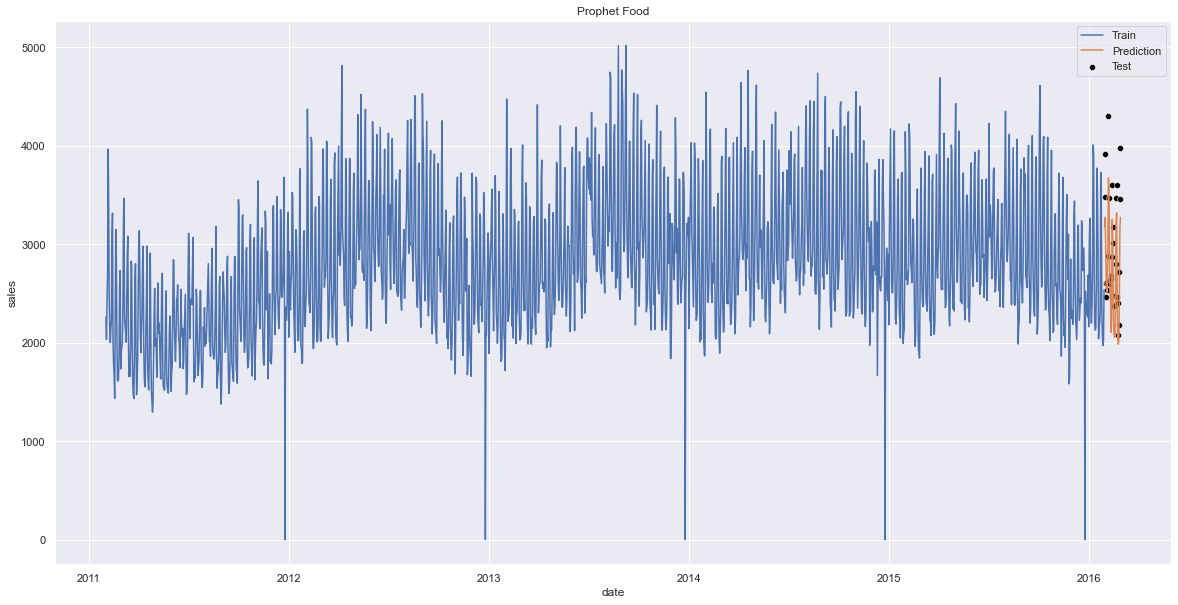

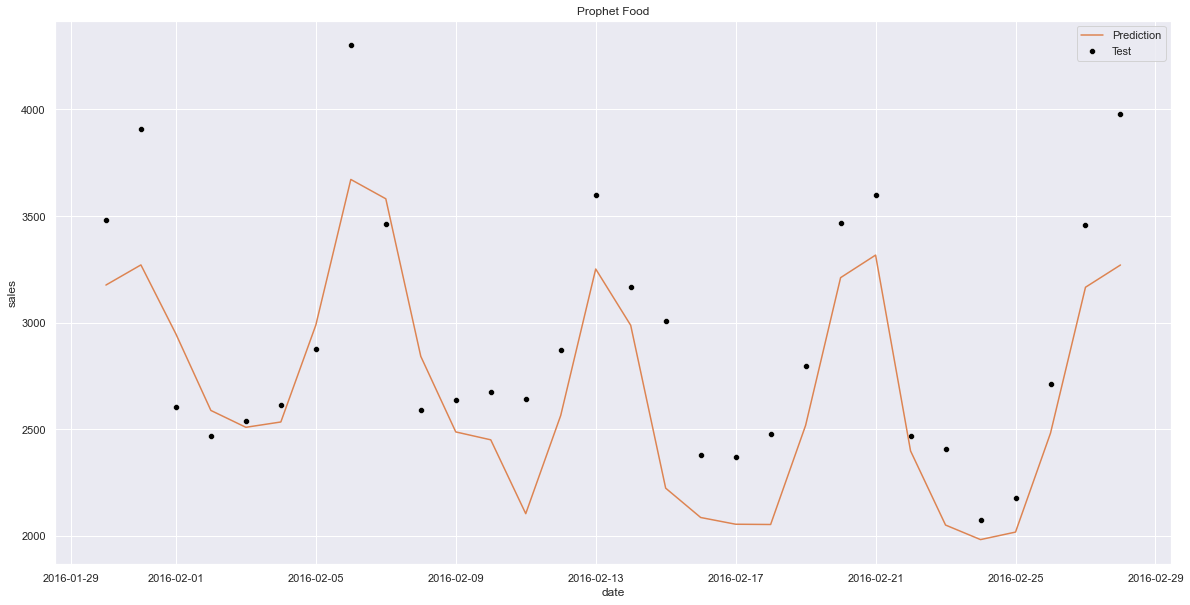

RMSE:	 17.24


In [174]:
# Modellierung Food

# Food-Datensatz splitten
train_food, test_food = temporal_train_test_split(food_grouped, test_size = 30)

# Prophet Data Frame kreiren
df_prophet_food = pd.DataFrame(food_grouped['sales'].astype('float'))
df_prophet_food.reset_index(inplace = True)
df_prophet_food.columns = ['ds', 'y']
display(df_prophet_food)
#display(df_prophet_food.info())

# Data Frame splitten
data_train_food, data_test_food = temporal_train_test_split(df_prophet_food, test_size = 30)

# Erklärende Variablen initialisieren auf Basis der Feature Importance
# OUTPUT SNAP passt nicht !!!!!!!!!!!!!!!!!!!!!
data_train_food['mean_price_dept2'] = train_food['mean_price_dept2'].astype('float').to_numpy()
data_train_food['snap'] = train_food['snap'].astype('int').to_numpy()
data_train_food['mean_price_dept3'] = train_food['mean_price_dept3'].astype('float').to_numpy()
data_train_food['mean_price_dept1'] = train_food['mean_price_dept1'].astype('float').to_numpy()
data_train_food['Month_April'] = train_food['Month_April'].astype('int').to_numpy()
data_train_food['Month_August'] = train_food['Month_August'].astype('int').to_numpy()
data_train_food['Month_December'] = train_food['Month_December'].astype('int').to_numpy()
data_train_food['Month_February'] = train_food['Month_February'].astype('int').to_numpy()
data_train_food['Month_January'] = train_food['Month_January'].astype('int').to_numpy()
data_train_food['Month_July'] = train_food['Month_July'].astype('int').to_numpy()
data_train_food['Month_June'] = train_food['Month_June'].astype('int').to_numpy()
data_train_food['Month_May'] = train_food['Month_May'].astype('int').to_numpy()
data_train_food['Month_November'] = train_food['Month_November'].astype('int').to_numpy()
data_train_food['Month_October'] = train_food['Month_October'].astype('int').to_numpy()
data_train_food['Month_September'] = train_food['Month_September'].astype('int').to_numpy()
data_train_food['Weekday_Friday'] = train_food['Weekday_Friday'].astype('int').to_numpy()
data_train_food['Weekday_Monday'] = train_food['Weekday_Monday'].astype('int').to_numpy()
data_train_food['Weekday_Saturday'] = train_food['Weekday_Saturday'].astype('int').to_numpy()
data_train_food['Weekday_Sunday'] = train_food['Weekday_Sunday'].astype('int').to_numpy()
data_train_food['Weekday_Thursday'] = train_food['Weekday_Thursday'].astype('int').to_numpy()
#display(data_train_food)
#data_train_food.to_excel("food_train.xlsx")

# SNAP passt nicht, überarbeiten !!!!!!!!!!!!!!!
# Prophet Modellierung
p_food = Prophet(yearly_seasonality = True, weekly_seasonality = True, holidays = holidays)
p_food.add_regressor('mean_price_dept1')
p_food.add_regressor('mean_price_dept2')
p_food.add_regressor('mean_price_dept3')
p_food.add_regressor('snap')
p_food.add_regressor('Month_April')
p_food.add_regressor('Month_August')
p_food.add_regressor('Month_December')
p_food.add_regressor('Month_February')
p_food.add_regressor('Month_January')
p_food.add_regressor('Month_July')
p_food.add_regressor('Month_June')
p_food.add_regressor('Month_May')
p_food.add_regressor('Month_November')
p_food.add_regressor('Month_October')
p_food.add_regressor('Month_September')
p_food.add_regressor('Weekday_Friday')
p_food.add_regressor('Weekday_Monday')
p_food.add_regressor('Weekday_Saturday')
p_food.add_regressor('Weekday_Sunday')
p_food.add_regressor('Weekday_Thursday')
p_food.fit(data_train_food)

future_food = p_food.make_future_dataframe(periods = len(test_food), freq='D', include_history = False)
future_food['mean_price_dept1'] = test_food['mean_price_dept1'].to_numpy()
future_food['mean_price_dept2'] = test_food['mean_price_dept2'].to_numpy()
future_food['mean_price_dept3'] = test_food['mean_price_dept3'].to_numpy()
future_food['snap'] = test_food['snap'].to_numpy()
future_food['Month_April'] = test_food['Month_April'].to_numpy()
future_food['Month_August'] = test_food['Month_August'].to_numpy()
future_food['Month_December'] = test_food['Month_December'].to_numpy()
future_food['Month_February'] = test_food['Month_February'].to_numpy()
future_food['Month_January'] = test_food['Month_January'].to_numpy()
future_food['Month_July'] = test_food['Month_July'].to_numpy()
future_food['Month_June'] = test_food['Month_June'].to_numpy()
future_food['Month_May'] = test_food['Month_May'].to_numpy()
future_food['Month_November'] = test_food['Month_November'].to_numpy()
future_food['Month_October'] = test_food['Month_October'].to_numpy()
future_food['Month_September'] = test_food['Month_September'].to_numpy()
future_food['Weekday_Friday'] = test_food['Weekday_Friday'].to_numpy()
future_food['Weekday_Monday'] = test_food['Weekday_Monday'].to_numpy()
future_food['Weekday_Saturday'] = test_food['Weekday_Saturday'].to_numpy()
future_food['Weekday_Sunday'] = test_food['Weekday_Sunday'].to_numpy()
future_food['Weekday_Thursday'] = test_food['Weekday_Thursday'].to_numpy()
#display(future_food)

forecast_food = p_food.predict(future_food)
forecast_food.set_index('ds', inplace = True)
#display(forecast_food)
# OUTPUT passt nicht !!!!!!!!!!!!!!!!!!!!!

sns.lineplot(data = train_food['sales'], label = 'Train')
sns.scatterplot(data = test_food['sales'], color = 'black', label = 'Test')
sns.lineplot(data = forecast_food['yhat'], label = 'Prediction')
plt.title('Prophet Food')
plt.show()

sns.scatterplot(data = test_food['sales'], color = 'black', label = 'Test')
sns.lineplot(data = forecast_food['yhat'], color = sns.color_palette('deep').as_hex()[1], label = 'Prediction')
plt.title('Prophet Food')
plt.show()

Prophet_MSE_Food = MSE(y_true = test_food['sales'], y_pred = forecast_food['yhat'])
Prophet_RMSE_Food = sqrt(Prophet_MSE_Food)
print('RMSE:\t %4.2f' % Prophet_RMSE_Food)

In [118]:
# Evaluation Food (Kreuzvalidierung)

# Initial = Anzahl Trainingsdaten
# Period = Schrittweise Erweiterung des Prognoseintervalls
# Horizon = Prognoseintervall gemäß Test-Size

display(data_train_food.value_counts('ds'))
scores_food = cross_validation(p_food, initial='1500 days', period='30 days', horizon ='30 days')
metrics_food = performance_metrics(scores_food)
display(metrics_food[['horizon', 'rmse']])

print('RMSE:\t %4.2f' % (metrics_food['rmse'].mean()))

ds
2011-02-01    1
2014-06-10    1
2014-06-08    1
2014-06-07    1
2014-06-06    1
             ..
2012-09-27    1
2012-09-26    1
2012-09-25    1
2012-09-24    1
2016-01-29    1
Length: 1824, dtype: int64

INFO:prophet:Making 10 forecasts with cutoffs between 2015-04-04 00:00:00 and 2015-12-30 00:00:00


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:prophet:Skipping MAPE because y close to 0


horizon        rmse
0   3 days  399.871662
1   4 days  321.522198
2   5 days  268.146668
3   6 days  272.446109
4   7 days  254.648402
5   8 days  224.960937
6   9 days  159.417979
7  10 days  202.375863
8  11 days  257.829601
9  12 days  278.234520
10 13 days  263.003915
11 14 days  203.763489
12 15 days  190.623183
13 16 days  194.411206
14 17 days  255.541766
15 18 days  247.028996
16 19 days  290.697095
17 20 days  266.589597
18 21 days  300.839460
19 22 days  302.627161
20 23 days  353.919443
21 24 days  374.787008
22 25 days  598.521553
23 26 days  591.601090
24 27 days  614.133370
25 28 days  405.518581
26 29 days  374.613375
27 30 days  303.280470

RMSE:	 313.25


ds      y
0    2011-02-01  392.0
1    2011-02-02  268.0
2    2011-02-03  467.0
3    2011-02-04  346.0
4    2011-02-05  769.0
...         ...    ...
1849 2016-02-24  473.0
1850 2016-02-25  451.0
1851 2016-02-26  525.0
1852 2016-02-27  600.0
1853 2016-02-28  740.0

[1854 rows x 2 columns]

<ipython-input-60-a167a4eefd09>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_train_hobbies['mean_price_dept1'] = train_hobbies['mean_price_dept1'].astype('float').to_numpy()
<ipython-input-60-a167a4eefd09>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_train_hobbies['mean_price_dept2'] = train_hobbies['mean_price_dept2'].astype('float').to_numpy()
<ipython-input-60-a167a4eefd09>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

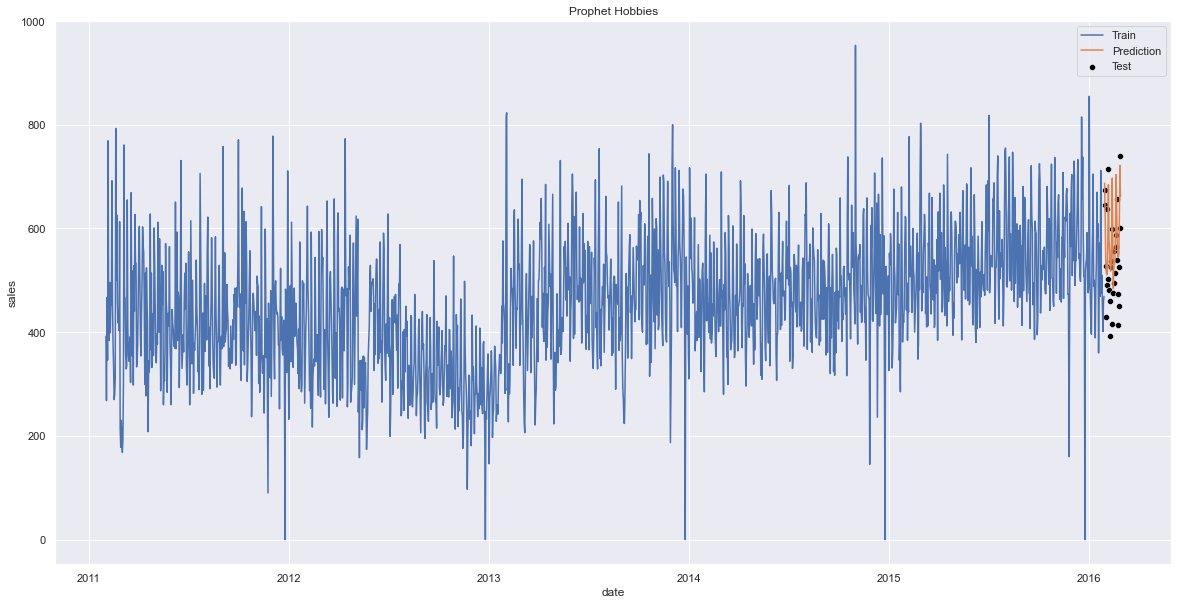

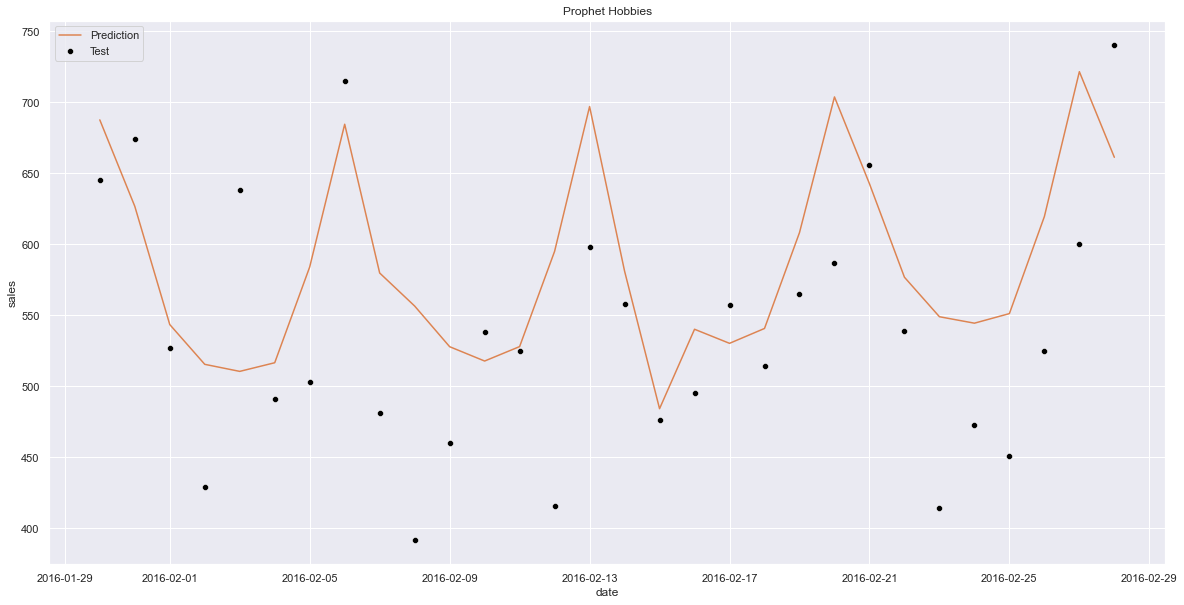

RMSE:	 8.23


In [60]:
# Modellierung Hobbies

# Hobbies-Datensatz splitten
train_hobbies, test_hobbies = temporal_train_test_split(hobbies_grouped, test_size = 30)

# Prophet Data Frame kreiren
df_prophet_hobbies = pd.DataFrame(hobbies_grouped['sales'].astype('float'))
df_prophet_hobbies.reset_index(inplace = True)
df_prophet_hobbies.columns = ['ds', 'y']
display(df_prophet_hobbies)
#display(df_prophet_hobbies.info())

# Data Frame splitten
data_train_hobbies, data_test_hobbies = temporal_train_test_split(df_prophet_hobbies, test_size = 30)

# Erklärende Variablen initialisieren auf Basis der Feature Importance
data_train_hobbies['mean_price_dept1'] = train_hobbies['mean_price_dept1'].astype('float').to_numpy()
data_train_hobbies['mean_price_dept2'] = train_hobbies['mean_price_dept2'].astype('float').to_numpy() 
data_train_hobbies['Month_December'] = train_hobbies['Month_December'].astype('int').to_numpy()
data_train_hobbies['Month_April'] = train_hobbies['Month_April'].astype('int').to_numpy()
data_train_hobbies['Month_February'] = train_hobbies['Month_February'].astype('int').to_numpy()
data_train_hobbies['Month_January'] = train_hobbies['Month_January'].astype('int').to_numpy()
data_train_hobbies['Month_July'] = train_hobbies['Month_July'].astype('int').to_numpy()
data_train_hobbies['Month_June'] = train_hobbies['Month_June'].astype('int').to_numpy()
data_train_hobbies['Month_March'] = train_hobbies['Month_March'].astype('int').to_numpy()
data_train_hobbies['Month_November'] = train_hobbies['Month_November'].astype('int').to_numpy()
data_train_hobbies['Month_September'] = train_hobbies['Month_September'].astype('int').to_numpy()
data_train_hobbies['Weekday_Friday'] = train_hobbies['Weekday_Friday'].astype('int').to_numpy()
data_train_hobbies['Weekday_Monday'] = train_hobbies['Weekday_Monday'].astype('int').to_numpy()
data_train_hobbies['Weekday_Saturday'] = train_hobbies['Weekday_Saturday'].astype('int').to_numpy()
data_train_hobbies['Weekday_Sunday'] = train_hobbies['Weekday_Sunday'].astype('int').to_numpy()
#display(data_train_hobbies)
#data_train_hobbies.to_excel("hobbies_train.xlsx")

# Prophet Modellierung
p_hobbies = Prophet(yearly_seasonality = True, weekly_seasonality = True, holidays = holidays)
p_hobbies.add_regressor('mean_price_dept1')
p_hobbies.add_regressor('mean_price_dept2')
p_hobbies.add_regressor('Month_December')
p_hobbies.add_regressor('Month_April')
p_hobbies.add_regressor('Month_February')
p_hobbies.add_regressor('Month_January')
p_hobbies.add_regressor('Month_July')
p_hobbies.add_regressor('Month_June')
p_hobbies.add_regressor('Month_March')
p_hobbies.add_regressor('Month_November')
p_hobbies.add_regressor('Month_September')
p_hobbies.add_regressor('Weekday_Friday')
p_hobbies.add_regressor('Weekday_Monday')
p_hobbies.add_regressor('Weekday_Saturday')
p_hobbies.add_regressor('Weekday_Sunday')
p_hobbies.fit(data_train_hobbies)

future_hobbies = p_hobbies.make_future_dataframe(periods = len(test_hobbies), freq='D', include_history = False)
future_hobbies['mean_price_dept1'] = test_hobbies['mean_price_dept1'].to_numpy()
future_hobbies['mean_price_dept2'] = test_hobbies['mean_price_dept2'].to_numpy()
future_hobbies['Month_December'] = test_hobbies['Month_December'].to_numpy()
future_hobbies['Month_April'] = test_hobbies['Month_April'].to_numpy()
future_hobbies['Month_February'] = test_hobbies['Month_February'].to_numpy()
future_hobbies['Month_January'] = test_hobbies['Month_January'].to_numpy()
future_hobbies['Month_July'] = test_hobbies['Month_July'].to_numpy()
future_hobbies['Month_June'] = test_hobbies['Month_June'].to_numpy()
future_hobbies['Month_March'] = test_hobbies['Month_March'].to_numpy()
future_hobbies['Month_November'] = test_hobbies['Month_November'].to_numpy()
future_hobbies['Month_September'] = test_hobbies['Month_September'].to_numpy()
future_hobbies['Weekday_Friday'] = test_hobbies['Weekday_Friday'].to_numpy()
future_hobbies['Weekday_Monday'] = test_hobbies['Weekday_Monday'].to_numpy()
future_hobbies['Weekday_Saturday'] = test_hobbies['Weekday_Saturday'].to_numpy()
future_hobbies['Weekday_Sunday'] = test_hobbies['Weekday_Sunday'].to_numpy()
#display(future_hobbies)

forecast_hobbies = p_hobbies.predict(future_hobbies)
forecast_hobbies.set_index('ds', inplace = True)
#display(forecast_hobbies)

sns.lineplot(data = train_hobbies['sales'], label = 'Train')
sns.scatterplot(data = test_hobbies['sales'], color = 'black', label = 'Test')
sns.lineplot(data = forecast_hobbies['yhat'], label = 'Prediction')
plt.title('Prophet Hobbies')
plt.show()

sns.scatterplot(data = test_hobbies['sales'], color = 'black', label = 'Test')
sns.lineplot(data = forecast_hobbies['yhat'], color = sns.color_palette('deep').as_hex()[1], label = 'Prediction')
plt.title('Prophet Hobbies')
plt.show()

#print('MAE:\t %4.2f' % (MAE(y_true = test_hobbies['sales'], y_pred = forecast_hobbies['yhat'])))
Prophet_MSE_Hobbies = MSE(y_true = test_hobbies['sales'], y_pred = forecast_hobbies['yhat'])
Prophet_RMSE_Hobbies = sqrt(Prophet_MSE_Hobbies)
print('RMSE:\t %4.2f' % Prophet_RMSE_Hobbies)

In [117]:
# Evaluation Hobbies (Kreuzvalidierung)

# Initial = Anzahl Trainingsdaten
# Period = Schrittweise Erweiterung des Prognoseintervalls
# Horizon = Prognoseintervall gemäß Test-Size

display(data_train_hobbies.value_counts('ds'))
scores_hobbies = cross_validation(p_hobbies, initial='1500 days', period='30 days', horizon ='30 days')
metrics_hobbies = performance_metrics(scores_hobbies)
display(metrics_hobbies[['horizon', 'rmse']])
print('RMSE:\t %4.2f' % (metrics_hobbies['rmse'].mean()))

ds
2011-02-01    1
2014-06-10    1
2014-06-08    1
2014-06-07    1
2014-06-06    1
             ..
2012-09-27    1
2012-09-26    1
2012-09-25    1
2012-09-24    1
2016-01-29    1
Length: 1824, dtype: int64

INFO:prophet:Making 10 forecasts with cutoffs between 2015-04-04 00:00:00 and 2015-12-30 00:00:00


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:prophet:Skipping MAPE because y close to 0


horizon        rmse
0   3 days   86.228507
1   4 days   77.422903
2   5 days   69.446986
3   6 days   77.880677
4   7 days   84.231204
5   8 days   81.348835
6   9 days   76.303183
7  10 days   70.430307
8  11 days   74.092023
9  12 days   60.597800
10 13 days   61.730181
11 14 days   57.794238
12 15 days   58.421339
13 16 days   63.956982
14 17 days   73.952310
15 18 days   71.598248
16 19 days   78.463255
17 20 days   76.544950
18 21 days   84.764677
19 22 days   73.027615
20 23 days   71.267785
21 24 days   68.452797
22 25 days  113.503366
23 26 days  118.503286
24 27 days  118.975829
25 28 days   86.847734
26 29 days   78.997425
27 30 days  102.807196

RMSE:	 79.20


ds       y
0    2011-02-01   401.0
1    2011-02-02   330.0
2    2011-02-03   402.0
3    2011-02-04   411.0
4    2011-02-05   706.0
...         ...     ...
1849 2016-02-24   820.0
1850 2016-02-25   769.0
1851 2016-02-26   849.0
1852 2016-02-27  1270.0
1853 2016-02-28  1479.0

[1854 rows x 2 columns]

<ipython-input-62-410449e66f3b>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_train_household['mean_price_dept1'] = train_household['mean_price_dept1'].astype('float').to_numpy()
<ipython-input-62-410449e66f3b>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_train_household['mean_price_dept2'] = train_household['mean_price_dept2'].astype('float').to_numpy()
<ipython-input-62-410449e66f3b>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

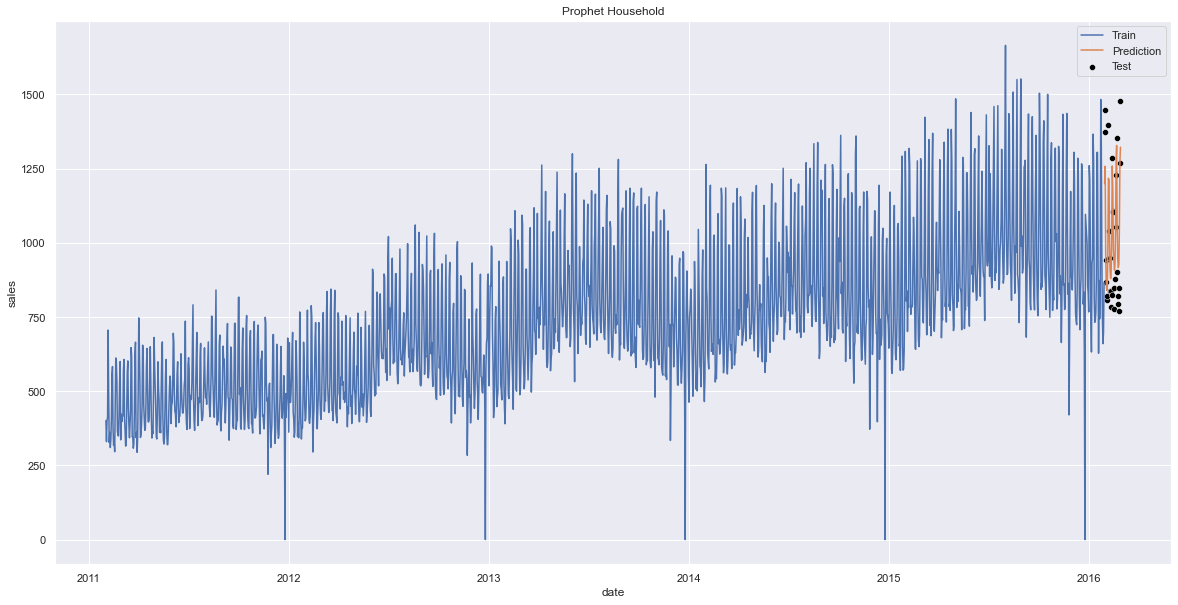

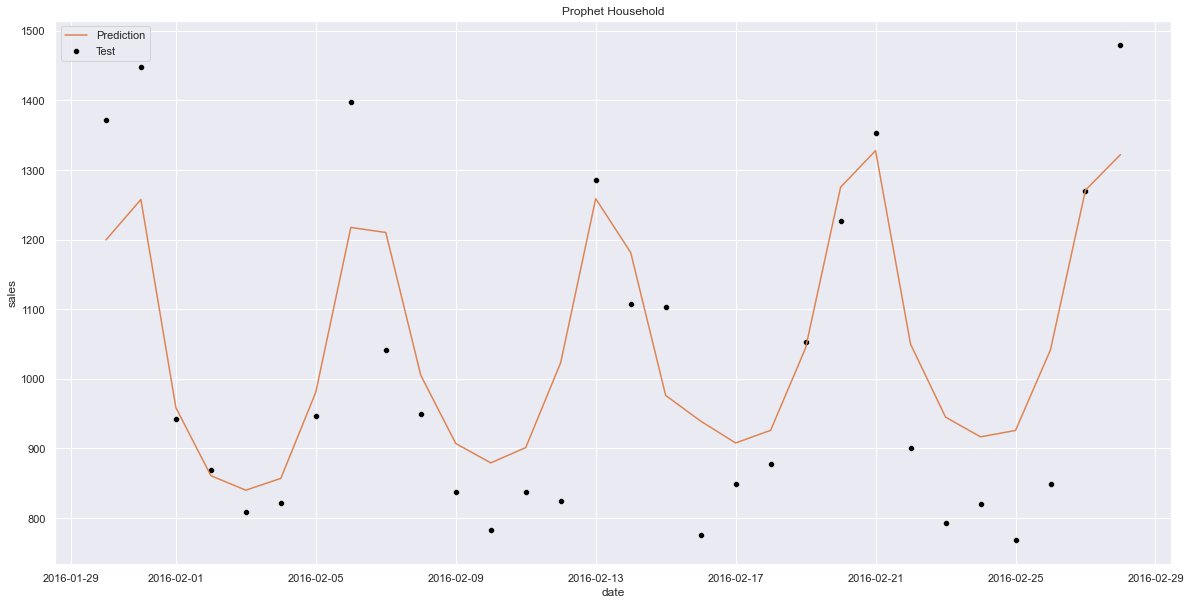

RMSE:	 9.68


In [62]:
# Modellierung Household

# Household-Datensatz splitten
train_household, test_household = temporal_train_test_split(household_grouped, test_size = 30)

# Prophet Data Frame kreiren
df_prophet_household = pd.DataFrame(household_grouped['sales'].astype('float'))
df_prophet_household.reset_index(inplace = True)
df_prophet_household.columns = ['ds', 'y']
display(df_prophet_household)
#display(df_prophet_household.info())

# Data Frame splitten
data_train_household, data_test_household = temporal_train_test_split(df_prophet_household, test_size = 30)

# Erklärende Variablen initialisieren auf Basis der Feature Importance
data_train_household['mean_price_dept1'] = train_household['mean_price_dept1'].astype('float').to_numpy()
data_train_household['mean_price_dept2'] = train_household['mean_price_dept2'].astype('float').to_numpy()
data_train_household['Month_December'] = train_household['Month_December'].astype('int').to_numpy()
data_train_household['Month_August'] = train_household['Month_August'].astype('int').to_numpy()
data_train_household['Month_May'] = train_household['Month_May'].astype('int').to_numpy()
data_train_household['Month_January'] = train_household['Month_January'].astype('int').to_numpy()
data_train_household['Month_July'] = train_household['Month_July'].astype('int').to_numpy()
data_train_household['Weekday_Friday'] = train_household['Weekday_Friday'].astype('int').to_numpy()
data_train_household['Weekday_Monday'] = train_household['Weekday_Monday'].astype('int').to_numpy()
data_train_household['Weekday_Saturday'] = train_household['Weekday_Saturday'].astype('int').to_numpy()
data_train_household['Weekday_Sunday'] = train_household['Weekday_Sunday'].astype('int').to_numpy()
#display(data_train_household)
#data_train_household.to_excel("household_train.xlsx")

# Prophet Modellierung
p_household = Prophet(yearly_seasonality = True, weekly_seasonality = True, holidays = holidays)
p_household.add_regressor('mean_price_dept1')
p_household.add_regressor('mean_price_dept2')
p_household.add_regressor('Month_December')
p_household.add_regressor('Month_August')
p_household.add_regressor('Month_May')
p_household.add_regressor('Month_January')
p_household.add_regressor('Month_July')
p_household.add_regressor('Weekday_Friday')
p_household.add_regressor('Weekday_Monday')
p_household.add_regressor('Weekday_Saturday')
p_household.add_regressor('Weekday_Sunday')
p_household.fit(data_train_household)

future_household = p_household.make_future_dataframe(periods = len(test_household), freq='D', include_history = False)
future_household['mean_price_dept1'] = test_household['mean_price_dept1'].to_numpy()
future_household['mean_price_dept2'] = test_household['mean_price_dept2'].to_numpy()
future_household['Month_December'] = test_household['Month_December'].to_numpy()
future_household['Month_April'] = test_household['Month_April'].to_numpy()
future_household['Month_August'] = test_household['Month_August'].to_numpy()
future_household['Month_May'] = test_household['Month_May'].to_numpy()
future_household['Month_January'] = test_household['Month_January'].to_numpy()
future_household['Month_July'] = test_household['Month_July'].to_numpy()
future_household['Weekday_Friday'] = test_household['Weekday_Friday'].to_numpy()
future_household['Weekday_Monday'] = test_household['Weekday_Monday'].to_numpy()
future_household['Weekday_Saturday'] = test_household['Weekday_Saturday'].to_numpy()
future_household['Weekday_Sunday'] = test_household['Weekday_Sunday'].to_numpy()
#display(future_household)

forecast_household = p_household.predict(future_household)
forecast_household.set_index('ds', inplace = True)
#display(forecast_household)
#forecast_household.to_excel("fcst_household.xlsx") -->
# Bug: Wieso ist das Cultural_Event_1 doppelt im Forecast enthalten? "Zwei Events an einem Tag"-Problem ? --> Lösung: Duplikate manuell entfernen?

sns.lineplot(data = train_household['sales'], label = 'Train')
sns.scatterplot(data = test_household['sales'], color = 'black', label = 'Test')
sns.lineplot(data = forecast_household['yhat'], label = 'Prediction')
plt.title('Prophet Household')
plt.show()

sns.scatterplot(data = test_household['sales'], color = 'black', label = 'Test')
sns.lineplot(data = forecast_household['yhat'], color = sns.color_palette('deep').as_hex()[1], label = 'Prediction')
plt.title('Prophet Household')
plt.show()

Prophet_MSE_Household = MSE(y_true = test_household['sales'], y_pred = forecast_household['yhat'])
Prophet_RMSE_Household = sqrt(Prophet_MSE_Household)
print('RMSE:\t %4.2f' % Prophet_RMSE_Household)

In [113]:
# Evaluation Household (Kreuzvalidierung)

# Initial = Anzahl Trainingsdaten
# Period = Schrittweise Erweiterung des Prognoseintervalls
# Horizon = Prognoseintervall gemäß Test-Size

display(data_train_household.value_counts('ds'))
scores_household = cross_validation(p_household, initial='1500 days', period='30 days', horizon ='30 days')
metrics_household = performance_metrics(scores_household)
display(metrics_household[['horizon', 'rmse']])
print('RMSE:\t %4.2f' % (metrics_household['rmse'].mean()))

ds
2011-02-01    1
2014-06-10    1
2014-06-08    1
2014-06-07    1
2014-06-06    1
             ..
2012-09-27    1
2012-09-26    1
2012-09-25    1
2012-09-24    1
2016-01-29    1
Length: 1824, dtype: int64

INFO:prophet:Making 10 forecasts with cutoffs between 2015-04-04 00:00:00 and 2015-12-30 00:00:00


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:prophet:Skipping MAPE because y close to 0


horizon        rmse
0   3 days  105.237989
1   4 days   87.569024
2   5 days   78.328182
3   6 days   91.290106
4   7 days   96.881295
5   8 days  104.746862
6   9 days   90.176016
7  10 days   91.772439
8  11 days   85.086955
9  12 days   96.571323
10 13 days   93.383258
11 14 days   96.739070
12 15 days   92.688979
13 16 days   95.681099
14 17 days   96.215801
15 18 days   81.568849
16 19 days   80.131569
17 20 days   77.571023
18 21 days  105.982380
19 22 days  117.937585
20 23 days  117.722503
21 24 days  115.601630
22 25 days  192.338494
23 26 days  201.462480
24 27 days  199.624627
25 28 days  128.769316
26 29 days  130.638559
27 30 days  154.941130

RMSE:	 110.95


Food  Hobbies  Household  Total
2011-02-01  2258      392        401   3051
2011-02-02  2032      268        330   2630
2011-02-03  2407      467        402   3276
2011-02-04  2693      346        411   3450
2011-02-05  3962      769        706   5437
...          ...      ...        ...    ...
2016-02-24  1982      544        916   3443
2016-02-25  2017      551        925   3494
2016-02-26  2481      619       1041   4142
2016-02-27  3165      721       1271   5158
2016-02-28  3270      661       1322   5253

[1854 rows x 4 columns]

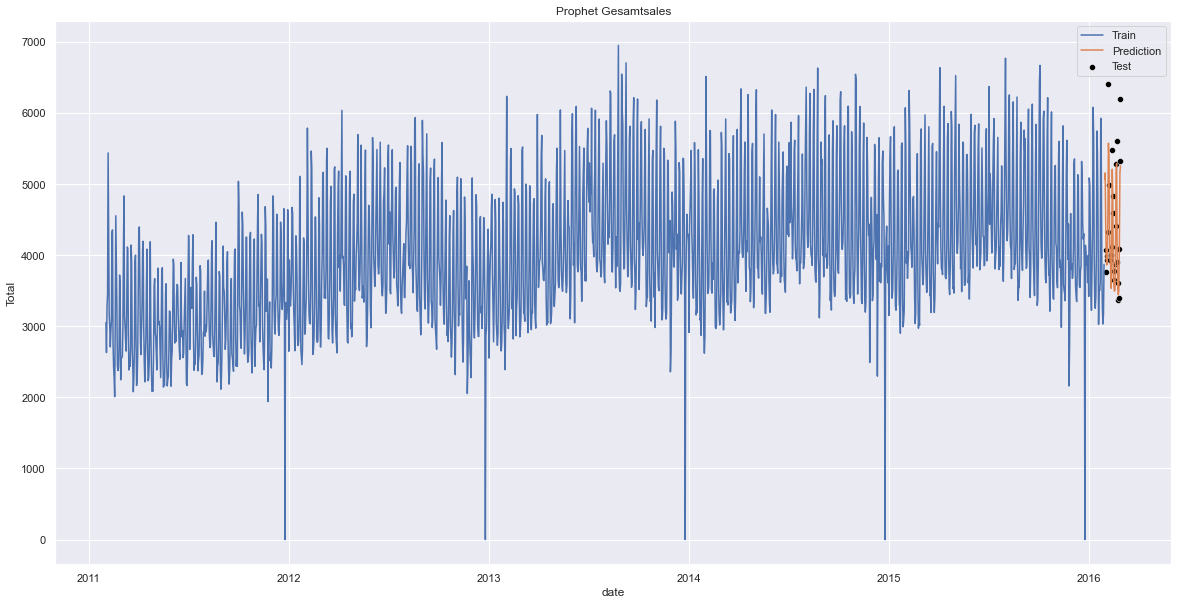

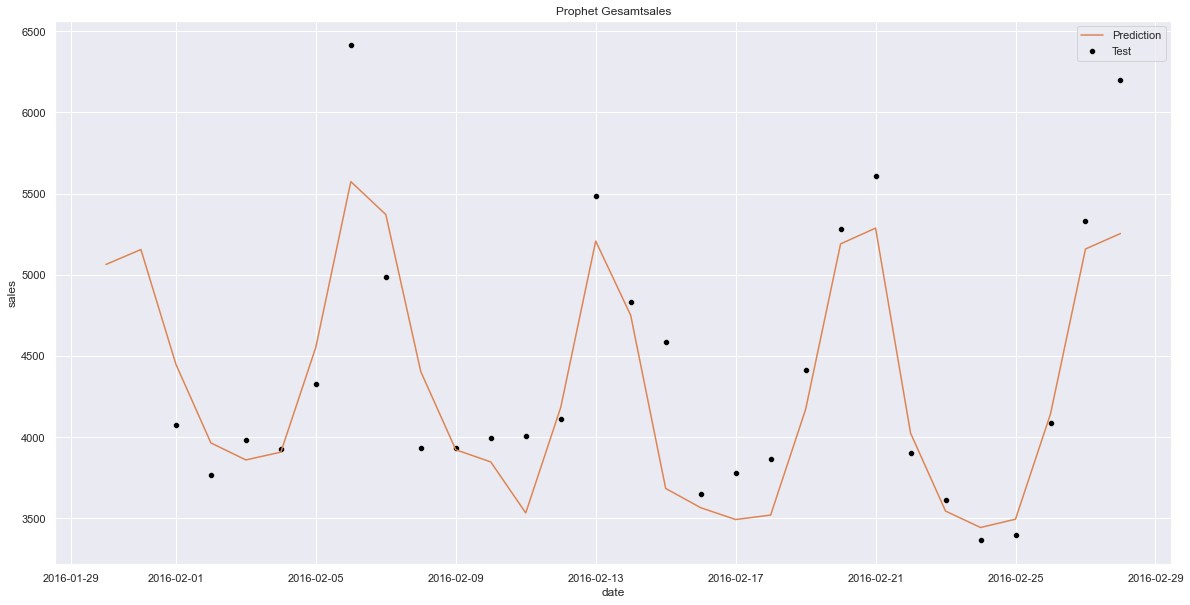

In [129]:
# Aggregation der Zeitreihen zu einer Gesamt-Zeitreihe & Visualisierung

# Trainingdaten
#display(train_food['sales'])
#display(train_hobbies['sales'])
#display(train_household['sales'])
prophet_train_agg = pd.merge(train_food['sales'], train_hobbies['sales'], on= "date")
prophet_train_agg = pd.merge(prophet_train_agg, train_household['sales'], on='date')
prophet_train_agg['Total'] = prophet_train_agg.sum(axis=1)
prophet_train_agg = prophet_train_agg.rename(columns={"sales_x": "Food", "sales_y": "Hobbies", "sales": "Household"})
#display(prophet_train_agg)

# Testdaten
#display(forecast_food['yhat'])
#display(forecast_hobbies['yhat'])
#display(forecast_household['yhat'])
prophet_test_agg = pd.merge(forecast_food['yhat'], forecast_hobbies['yhat'], on= "ds")
prophet_test_agg = pd.merge(prophet_test_agg, forecast_household['yhat'], on='ds')
prophet_test_agg['Total'] = prophet_test_agg.sum(axis=1)
prophet_test_agg = prophet_test_agg.rename(columns={"yhat_x": "Food", "yhat_y": "Hobbies", "yhat": "Household"})
#display(prophet_test_agg)

# Trainings- und Testdaten untereinander mergen
prophet_total_agg = prophet_train_agg.append(prophet_test_agg)
prophet_total_agg = prophet_total_agg.astype('int')
display(prophet_total_agg)

# Visualisierung
data_february = data_grouped.loc['2016-02-01':'2016-02-29']
#display(data_february)
sns.lineplot(data = prophet_train_agg['Total'], label = 'Train')
sns.scatterplot(data = data_february['sales'], color = 'black', label = 'Test')
sns.lineplot(data = prophet_test_agg['Total'], label = 'Prediction')
plt.title('Prophet Gesamtsales')
plt.show()

sns.scatterplot(data = data_february['sales'], color = 'black', label = 'Test')
sns.lineplot(data = prophet_test_agg['Total'], color = sns.color_palette('deep').as_hex()[1], label = 'Prediction')
plt.title('Prophet Gesamtsales')
plt.show()

### 3.4 Evaluation

## 4. Absatzprognose

In [96]:
#prices_data.tail()
#calendar_data.tail()

Unnamed: 0      item_id  week_id  price
661819      698395  FOODS_3_827    11605    1.0
661820      698396  FOODS_3_827    11606    1.0
661821      698397  FOODS_3_827    11607    1.0
661822      698398  FOODS_3_827    11608    1.0
661823      698399  FOODS_3_827    11609    1.0

In [116]:
#Datensatz für die Abatzprognose zusammenfügen
forecast_data = pd.merge(prices_data, calendar_data, on ="week_id")
forecast_data = forecast_data.loc['2016-03-01':'2016-03-31']
forecast_data.set_index(['date'], inplace = True)
forecast_data.sort_index(axis = 0, ascending = True, inplace = True)
forecast_data = forecast_data.drop(['Unnamed: 0'], axis=1)


item_id  week_id  price event_name_1 event_type_1  \
date                                                                    
2016-03-01  HOUSEHOLD_1_188    11605   3.98          NaN          NaN   
2016-03-01      FOODS_2_121    11605   1.58          NaN          NaN   
2016-03-01      FOODS_2_195    11605   3.47          NaN          NaN   
2016-03-01  HOUSEHOLD_1_148    11605   5.92          NaN          NaN   
2016-03-01      FOODS_2_198    11605   8.98          NaN          NaN   

           event_name_2 event_type_2  snap  
date                                        
2016-03-01          NaN          NaN     1  
2016-03-01          NaN          NaN     1  
2016-03-01          NaN          NaN     1  
2016-03-01          NaN          NaN     1  
2016-03-01          NaN          NaN     1

In [122]:
forecast_data.event_type_1.value_counts()
### im März finden keine Cultural & Sporting Events statt -- aus den jeweiligen Modellen rausnehmen?

Cultural     6098
Religious    3049
National        0
Sporting        0
Name: event_type_1, dtype: int64

In [126]:
forecast_data.tail(500)

item_id  week_id  price event_name_1 event_type_1  \
date                                                                    
2016-03-31      FOODS_3_555    11609   1.68          NaN          NaN   
2016-03-31  HOUSEHOLD_1_022    11609   4.84          NaN          NaN   
2016-03-31      FOODS_2_234    11609   2.50          NaN          NaN   
2016-03-31  HOUSEHOLD_2_379    11609   4.44          NaN          NaN   
2016-03-31    HOBBIES_1_356    11609   5.76          NaN          NaN   
...                     ...      ...    ...          ...          ...   
2016-03-31    HOBBIES_1_061    11609   2.83          NaN          NaN   
2016-03-31      FOODS_1_159    11609   4.89          NaN          NaN   
2016-03-31  HOUSEHOLD_2_164    11609   8.47          NaN          NaN   
2016-03-31      FOODS_2_284    11609   2.47          NaN          NaN   
2016-03-31    HOBBIES_1_046    11609  18.72          NaN          NaN   

           event_name_2 event_type_2  snap  
date                                        
2016-03-31          NaN          NaN     0  
2016-03-31          NaN          NaN     0  
2016-03-31          NaN          NaN     0  
2016-03-31          NaN          NaN     0  
2016-03-31          NaN          NaN     0  
...                 ...          ...   ...  
2016-03-31          NaN          NaN     0  
2016-03-31          NaN          NaN     0  
2016-03-31          NaN          NaN     0  
2016-03-31          NaN          NaN     0  
2016-03-31          NaN          NaN     0  

[500 rows x 8 columns]

In [128]:
#Dummy-variablen codieren
forecast_data['Month'] = forecast_data.index.month_name()
forecast_data['Weekday'] = forecast_data.index.day_name()
forecast_data = pd.get_dummies(forecast_data, columns = ['event_name_1','event_type_1', 'Month', 'Weekday'], drop_first = False) #hier kein event type 2, weil nicht vorhanden im März
forecast_data.head(20)

item_id  week_id  price event_name_2 event_type_2  snap  \
date                                                                          
2016-03-01  HOUSEHOLD_1_188    11605   3.98          NaN          NaN     1   
2016-03-01      FOODS_2_121    11605   1.58          NaN          NaN     1   
2016-03-01      FOODS_2_195    11605   3.47          NaN          NaN     1   
2016-03-01  HOUSEHOLD_1_148    11605   5.92          NaN          NaN     1   
2016-03-01      FOODS_2_198    11605   8.98          NaN          NaN     1   
2016-03-01      FOODS_2_129    11605   9.54          NaN          NaN     1   
2016-03-01      FOODS_3_783    11605   5.44          NaN          NaN     1   
2016-03-01      FOODS_1_009    11605   2.24          NaN          NaN     1   
2016-03-01  HOUSEHOLD_1_199    11605   1.77          NaN          NaN     1   
2016-03-01      FOODS_2_100    11605   2.50          NaN          NaN     1   
2016-03-01    HOBBIES_1_122    11605   1.77          NaN          NaN     1   
2016-03-01      FOODS_1_011    11605   2.68          NaN          NaN     1   
2016-03-01      FOODS_1_049    11605   2.24          NaN          NaN     1   
2016-03-01      FOODS_1_051    11605   3.87          NaN          NaN     1   
2016-03-01  HOUSEHOLD_1_143    11605   1.97          NaN          NaN     1   
2016-03-01      FOODS_2_101    11605   5.98          NaN          NaN     1   
2016-03-01  HOUSEHOLD_1_338    11605   3.94          NaN          NaN     1   
2016-03-01      FOODS_2_102    11605  10.97          NaN          NaN     1   
2016-03-01      FOODS_3_588    11605   3.94          NaN          NaN     1   
2016-03-01    HOBBIES_1_294    11605   3.88          NaN          NaN     1   

            event_name_1_Easter  event_name_1_Purim End  \
date                                                      
2016-03-01                    0                       0   
2016-03-01                    0                       0   
2016-03-01                    0                       0   
2016-03-01                    0                       0   
2016-03-01                    0                       0   
2016-03-01                    0                       0   
2016-03-01                    0                       0   
2016-03-01                    0                       0   
2016-03-01                    0                       0   
2016-03-01                    0                       0   
2016-03-01                    0                       0   
2016-03-01                    0                       0   
2016-03-01                    0                       0   
2016-03-01                    0                       0   
2016-03-01                    0                       0   
2016-03-01                    0                       0   
2016-03-01                    0                       0   
2016-03-01                    0                       0   
2016-03-01                    0                       0   
2016-03-01                    0                       0   

            event_name_1_StPatricksDay  event_type_1_Cultural  \
date                                                            
2016-03-01                           0                      0   
2016-03-01                           0                      0   
2016-03-01                           0                      0   
2016-03-01                           0                      0   
2016-03-01                           0                      0   
2016-03-01                           0                      0   
2016-03-01                           0                      0   
2016-03-01                           0                      0   
2016-03-01                           0                      0   
2016-03-01                           0                      0   
2016-03-01                           0                      0   
2016-03-01                           0                      0   
2016-03-01                           0                      0   
2016-03